### Federated Learning of the simple CNN model as **FL-CovidCNN** using fedAvg

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices("GPU")

2024-05-29 10:36:18.557260: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-29 10:36:18.587663: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 10:36:18.587689: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 10:36:18.587709: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-29 10:36:18.593704: I tensorflow/core/platform/cpu_feature_g

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [ ]:
import pandas as pd
import random
import cv2
#from keras.utils.vis_utils import plot_model
import os.path
from PIL import Image
from skimage.io import imread, imsave, imshow, show, imread_collection, imshow_collection
import os
import glob
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
#import keras_tuner as kt
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow import keras
import logging
tf.config.set_visible_devices([], 'GPU')
from sklearn import preprocessing

# Set TensorFlow logging level to only display errors
tf.get_logger().setLevel(logging.ERROR)
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

from tqdm import tqdm
from tqdm.notebook import tqdm
import time

#import tensorflow_federated as tff
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from tqdm import tqdm
import time
import numpy as np
IMAGE_SIZE = 200

### Functions to Evaluate Models after Training

In [ ]:
import seaborn as sns
def getCorrectLabel(x):
        if x == 0:
            return 'Non-Covid'
        if x == 1:
            return 'Covid'

def D1_to_D2(y_pred):
    y_true = {'y_true':[i[0] for i in y_pred]}
    y_true_df = pd.DataFrame(y_true)
    y_true_df = pd.get_dummies(y_true_df, columns =['y_true'])
    output_label_y = np.array(y_true_df[y_true_df.columns])
    return output_label_y

def getModelEvaluation(model, test_features_,test_labels_):
    predicted_labels = model.predict(np.stack(test_features_))
    df = pd.DataFrame(predicted_labels)
    df['Predicted_Labels'] = np.array(df.iloc[:,:2]).argmax(axis =1)
    df['Predicted_Labels'] = df['Predicted_Labels'].apply(getCorrectLabel)
    if (test_labels_.shape[1]==2):
        df['Actual_Labels'] = test_labels_[:,:2].argmax(axis = 1)
    else:
        df['Actual_Labels'] = D1_to_D2(test_labels_)[:,:2].argmax(axis = 1)
    df['Actual_Labels'] = df['Actual_Labels'].apply(getCorrectLabel)
    cm = pd.crosstab(df.Predicted_Labels, df.Actual_Labels)
    fig = plt.figure(figsize=(20,5))
    ax1 = plt.subplot(121)
    sns.heatmap(cm,annot = True,cmap='Blues')
    ax1.set_title('')
    # Saving the figure.
    plt.savefig("test_Confusion_Matrix_with_i.jpg")
    plt.show()
    plt.close()

    test_labels__ = [i.argmax() for i in test_labels_]
    pred_list = [i.argmax() for i in predicted_labels]
    count = 0
    for i in range(test_labels_.shape[0]):
        if int(test_labels__[i]) == int(pred_list[i]):
            count+=1
    print("test accuracy = " + str((count/test_labels_.shape[0])*100)+'%')
    print('-------------------------------------------------------------------------------------------------')
    print('Model Metrics')
    # getting model predictions
    #test_predictions,_ = model.predict((x_test,y_test),20)
    predictions = pd.DataFrame(predicted_labels)#, columns=labels_ohe_names.columns
    predictions = list(predictions.idxmax(axis=1))
    test_labels__ = [i.argmax() for i in test_labels_]

    # evaluate model performance
    import model_evaluation_utils_ as meu
    meu.get_metrics(true_labels=test_labels__,
                    predicted_labels=predictions)

## Data Source

Hopital 1 (Datasets 1), Hospital 2 (Dataset2 2) and Hospital 3 (Datasets 3)

- https://github.com/ieee8023/covid-chestxray-dataset/tree/master/images (dataset3)
- https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset/ (dataset3)

- https://www.kaggle.com/datasets/maedemaftouni/large-covid19-ct-slice-dataset (dataset2)

- https://www.kaggle.com/datasets/mehradaria/covid19-lung-ct-scans (Dataset1)
- https://www.kaggle.com/datasets/plameneduardo/sarscov2-ctscan-dataset (Dataset1)

####  Loading NumPy Array Datasets:

In [ ]:
# # # Load the array from the file
input_data_x_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset1_input.npy')
output_label_y_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset1_output.npy')
input_data_x_2_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset2_input.npy')
output_label_y_2_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset2_output.npy')
input_data_x_3_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset3_input.npy')#.astype('float64')
output_label_y_3_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset3_output.npy')
#input_data_x_4_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages/Dataset4_input.npy')
#output_label_y_4_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages/Dataset4_output.npy')

#Now loaded_arr contains the array loaded from the file
print('------------------ DATASET 1 ---------------------')
print('Input_x Data Shape: \n{0}'.format(input_data_x_load.shape))
print('Output_y Data Shape: \n{0}'.format(output_label_y_load.shape))

print('------------------ DATASET 2 ---------------------')
print('Input_x Data Shape: \n{0}'.format(input_data_x_2_load.shape))
print('Output_y Data Shape: \n{0}'.format(output_label_y_2_load.shape))

print('------------------ DATASET 3 ---------------------')
print('Input_x Data Shape: \n{0}'.format(input_data_x_3_load.shape))
print('Output_y Data Shape: \n{0}'.format(output_label_y_3_load.shape))

# print('------------------ DATASET 4 ---------------------')
# print('Input_x Data Shape: \n{0}'.format(input_data_x_4_load.shape))
# print('Output_y Data Shape: \n{0}'.format(output_label_y_4_load.shape))

------------------ DATASET 1 ---------------------
Input_x Data Shape: 
(4649, 200, 200, 1)
Output_y Data Shape: 
(4649, 2)
------------------ DATASET 2 ---------------------
Input_x Data Shape: 
(14486, 200, 200, 1)
Output_y Data Shape: 
(14486, 2)
------------------ DATASET 3 ---------------------
Input_x Data Shape: 
(2540, 200, 200, 1)
Output_y Data Shape: 
(2540, 2)


##### Data used to train teacher models for each client

In [ ]:
from sklearn.model_selection import train_test_split


train_features_dataset1, test_features_dataset1, train_labels_dataset1, test_labels_dataset1 = train_test_split(
    input_data_x_load[0:2500,:], output_label_y_load[0:2500,:], test_size=.20, random_state=25)

train_features_dataset2, test_features_dataset2, train_labels_dataset2, test_labels_dataset2 = train_test_split(
    input_data_x_2_load[0:6500,:], output_label_y_2_load[0:6500,:], test_size=.20, random_state=25)

train_features_dataset3, test_features_dataset3, train_labels_dataset3, test_labels_dataset3 = train_test_split(
    input_data_x_3_load[0:1200,:], output_label_y_3_load[0:1200,:], test_size=.20, random_state=25)

print('------ Training Teacher Models----------')
print('client 1 teacher dataset: ',train_features_dataset1.shape, test_features_dataset1.shape, train_labels_dataset1.shape, test_labels_dataset1.shape)
print('client 2 teacher dataset: ',train_features_dataset2.shape, test_features_dataset2.shape, train_labels_dataset2.shape, test_labels_dataset2.shape)
print('client 3 teacher dataset: ',train_features_dataset3.shape, test_features_dataset3.shape, train_labels_dataset3.shape, test_labels_dataset3.shape)

------ Training Teacher Models----------
client 1 teacher dataset:  (2000, 200, 200, 1) (500, 200, 200, 1) (2000, 2) (500, 2)
client 2 teacher dataset:  (5200, 200, 200, 1) (1300, 200, 200, 1) (5200, 2) (1300, 2)
client 3 teacher dataset:  (960, 200, 200, 1) (240, 200, 200, 1) (960, 2) (240, 2)


## Federated Learning Datasets

In [ ]:
def dataset_pixel_stat(dataset):
    mean_pixel_value = np.mean(dataset)
    variance_pixel_value = np.var(dataset)
    std_dev_pixel_value = np.std(dataset)
    # Display the computed statistics
    print("Mean Pixel Value:", mean_pixel_value)
    print("Variance of Pixel Values:", variance_pixel_value)
    print("Standard Deviation of Pixel Values:", std_dev_pixel_value)

    # Compute histograms of pixel values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(dataset.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title('Histogram of Pixel Values (Entire Dataset)')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

    # Assuming you have subsets 'subset1' and 'subset2' of the dataset
    # Compute histograms for each subset
    plt.subplot(1, 2, 2)
    plt.hist(dataset[0:500,:].flatten(), bins=50, color='red', alpha=0.7, label='Subset 1')
    plt.hist(dataset[501:1000,:].flatten(), bins=50, color='green', alpha=0.7, label='Subset 2')
    plt.hist(dataset[1001:1500,:].flatten(), bins=50, color='yellow', alpha=0.7, label='Subset 3')

    plt.title('Histogram of Pixel Values (Subsets)')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.legend()

    plt.show()

In [ ]:
print('------ Federated Training----------')
train_features_dataset1_fed, test_features_dataset1_fed, train_labels_dataset1_fed, test_labels_dataset1_fed = train_test_split(
    input_data_x_load[2501:3901,:], output_label_y_load[2501:3901,:], test_size=.20, random_state=25)
train_features_dataset2_fed, test_features_dataset2_fed, train_labels_dataset2_fed, test_labels_dataset2_fed = train_test_split(
    input_data_x_2_load[6501:10400,:], output_label_y_2_load[6501:10400,:], test_size=.20, random_state=25)
train_features_dataset3_fed, test_features_dataset3_fed, train_labels_dataset3_fed, test_labels_dataset3_fed = train_test_split(
    input_data_x_3_load[1201:,:], output_label_y_3_load[1201:,:], test_size=.20, random_state=25)
print('client 1 federated dataset: ', train_features_dataset1_fed.shape, test_features_dataset1_fed.shape, train_labels_dataset1_fed.shape, test_labels_dataset1_fed.shape)
print('client 2 federated dataset: ', train_features_dataset2_fed.shape, test_features_dataset2_fed.shape, train_labels_dataset2_fed.shape, test_labels_dataset2_fed.shape)
print('client 3 federated dataset: ', train_features_dataset3_fed.shape, test_features_dataset3_fed.shape, train_labels_dataset3_fed.shape, test_labels_dataset3_fed.shape)


------ Federated Training----------
client 1 federated dataset:  (1120, 200, 200, 1) (280, 200, 200, 1) (1120, 2) (280, 2)
client 2 federated dataset:  (3119, 200, 200, 1) (780, 200, 200, 1) (3119, 2) (780, 2)
client 3 federated dataset:  (1071, 200, 200, 1) (268, 200, 200, 1) (1071, 2) (268, 2)


---------------Client 1 sample Image -----------------


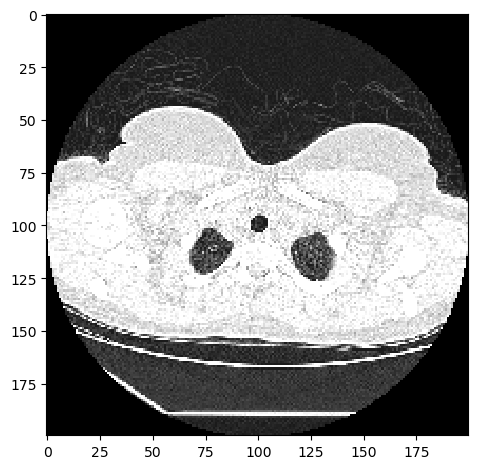

---------------Client 2 sample Image -----------------


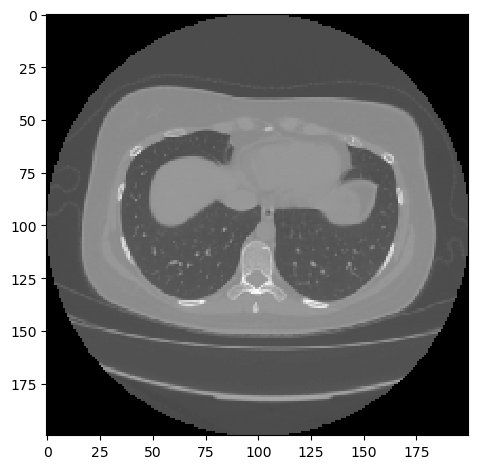

---------------Client 3 sample Image -----------------


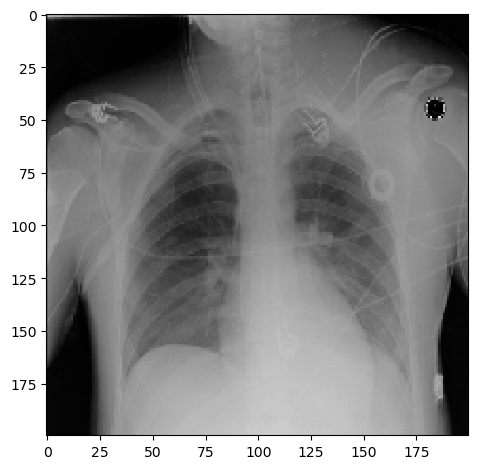

In [ ]:
print('---------------Client 1 sample Image -----------------')
imshow(train_features_dataset1_fed[0])
show()
print('---------------Client 2 sample Image -----------------')
imshow(train_features_dataset2_fed[0])
show()
print('---------------Client 3 sample Image -----------------')
imshow(train_features_dataset3_fed[100])
show()

In [ ]:
print('--------------------- Testing dataset--------------')
# Assuming client_images and client_labels are numpy arrays or lists of numpy arrays
X_test_combined = np.concatenate((test_features_dataset1_fed, test_features_dataset2_fed,
                                  test_features_dataset3_fed), axis=0)
y_test_combined = np.concatenate((test_labels_dataset1_fed, test_labels_dataset2_fed,
                                  test_labels_dataset3_fed), axis=0)

--------------------- Testing dataset--------------


### Preparing The Federated Dataset (non_iid Dataset )

Mean Pixel Value: 0.5149437324054628
Variance of Pixel Values: 0.13384306055452233
Standard Deviation of Pixel Values: 0.36584567860577816


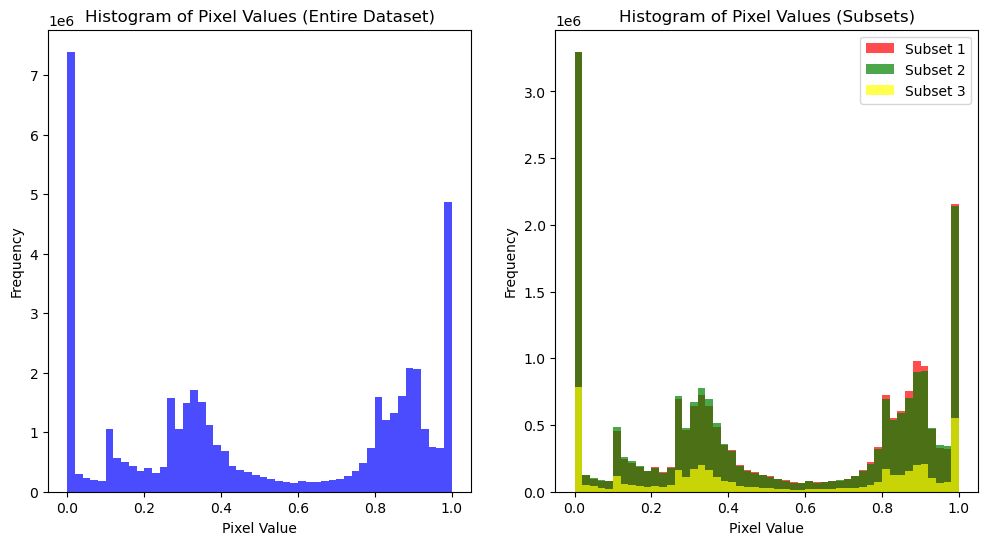

Mean Pixel Value: 0.2761424951121855
Variance of Pixel Values: 0.056925370933381306
Standard Deviation of Pixel Values: 0.23859038315359926


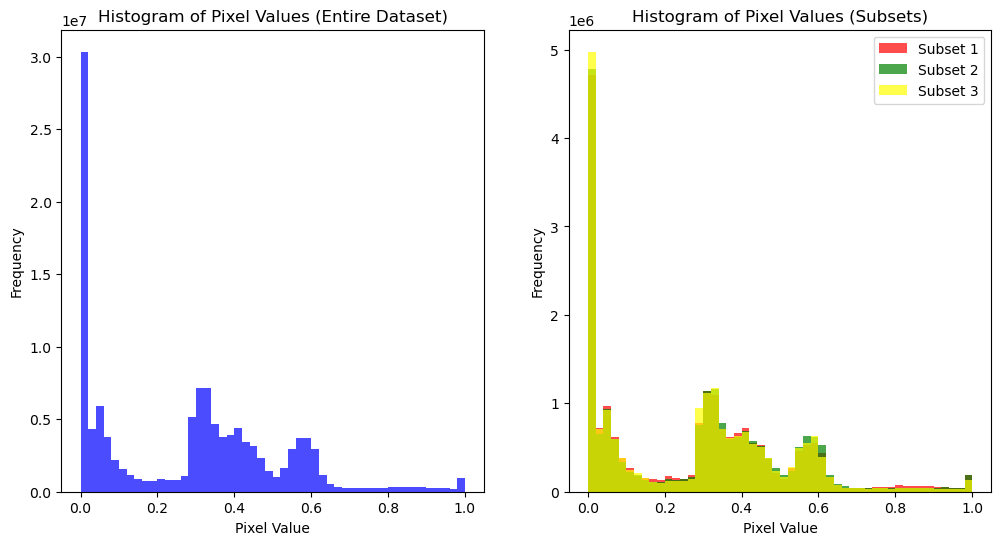

Mean Pixel Value: 0.5393774509803901
Variance of Pixel Values: 0.07674632723644069
Standard Deviation of Pixel Values: 0.2770312748345224


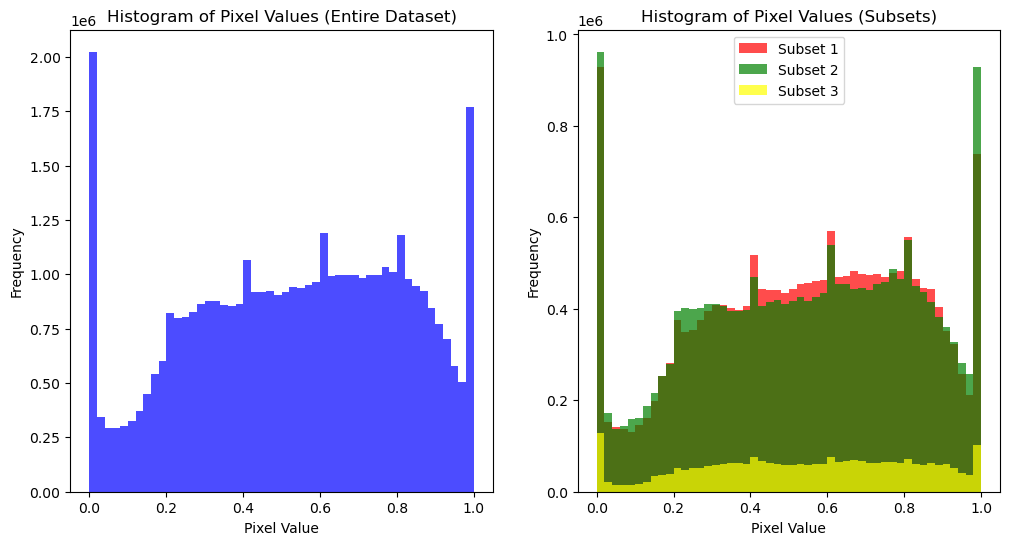

In [ ]:
dataset_pixel_stat(train_features_dataset1_fed)
dataset_pixel_stat(train_features_dataset2_fed)
dataset_pixel_stat(train_features_dataset3_fed)

###### non-iid Federated Dataset (unbalanced)

In [ ]:
client_data = [(train_features_dataset1_fed, train_labels_dataset1_fed),
              (train_features_dataset2_fed, train_labels_dataset2_fed),
              (train_features_dataset3_fed, train_labels_dataset3_fed)]#(train_features_dataset3_fed, train_labels_dataset3_fed)

NUM_CLIENTS = len(client_data)  # Number of clients
BATCH_SIZE = 20

def create_tf_dataset_for_client(client_dataset):
    """Create a tf.data.Dataset object for a client's data."""
    client_images, client_labels = client_dataset
    dataset = tf.data.Dataset.from_tensor_slices((client_images, client_labels))
    return dataset

client_datasets = [create_tf_dataset_for_client(data) for data in client_data]

def preprocess_dataset(dataset, batch_size=BATCH_SIZE , shuffle_buffer_size=100):
    """Preprocess the dataset."""
    return dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
#federated_clients
fed_clients = ['client_'+str(i) for i in range(1,NUM_CLIENTS+1)]

# Federated data preparation
federated_train_data_nonIID_unbalanced = [preprocess_dataset(dataset) for dataset in client_datasets]
print('Fedrated non-iid Unbalanced Dataset Data type: ', type(federated_train_data_nonIID_unbalanced))
print('Length: ', len(federated_train_data_nonIID_unbalanced))

Fedrated non-iid Unbalanced Dataset Data type:  <class 'list'>
Length:  3


###### non-iid Federated Dataset (balanced)

In [ ]:
client_data = [(train_features_dataset1_fed, train_labels_dataset1_fed),
              (train_features_dataset2_fed[0:1200,:], train_labels_dataset2_fed[0:1200,:]),
              (train_features_dataset3_fed, train_labels_dataset3_fed)]
client_datasets = [create_tf_dataset_for_client(data) for data in client_data]
# Federated data preparation
federated_train_data_nonIID_balanced = [preprocess_dataset(dataset) for dataset in client_datasets]
print('Fedrated non-iid balanced Dataset Data type: ', type(federated_train_data_nonIID_unbalanced))
print('Length: ', len(federated_train_data_nonIID_unbalanced))

Fedrated non-iid balanced Dataset Data type:  <class 'list'>
Length:  3


### Preparing The Federated Dataset (iid Dataset )

In [ ]:
train_features_dataset1_fed_iid, test_features_dataset1_fed_iid, train_labels_dataset1_fed_iid, test_labels_dataset1_fed_iid = train_test_split(
    input_data_x_2_load[6501:7901,:], output_label_y_2_load[6501:7901,:], test_size=.20, random_state=42)
train_features_dataset2_fed_iid, test_features_dataset2_fed_iid, train_labels_dataset2_fed_iid, test_labels_dataset2_fed_iid = train_test_split(
    input_data_x_2_load[7901:11800,:], output_label_y_2_load[7901:11800,:], test_size=.20, random_state=42)
train_features_dataset3_fed_iid, test_features_dataset3_fed_iid, train_labels_dataset3_fed_iid, test_labels_dataset3_fed_iid = train_test_split(
    input_data_x_2_load[11800:13139,:], output_label_y_2_load[11800:13139,:], test_size=.20, random_state=42)
print('client 1 federated dataset: ', train_features_dataset1_fed_iid.shape, test_features_dataset1_fed_iid.shape, train_labels_dataset1_fed_iid.shape, test_labels_dataset1_fed_iid.shape)
print('client 2 federated dataset: ', train_features_dataset2_fed_iid.shape, test_features_dataset2_fed_iid.shape, train_labels_dataset2_fed_iid.shape, test_labels_dataset2_fed_iid.shape)
print('client 3 federated dataset: ', train_features_dataset3_fed_iid.shape, test_features_dataset3_fed_iid.shape, train_labels_dataset3_fed_iid.shape, test_labels_dataset3_fed_iid.shape)

client 1 federated dataset:  (1120, 200, 200, 1) (280, 200, 200, 1) (1120, 2) (280, 2)
client 2 federated dataset:  (3119, 200, 200, 1) (780, 200, 200, 1) (3119, 2) (780, 2)
client 3 federated dataset:  (1071, 200, 200, 1) (268, 200, 200, 1) (1071, 2) (268, 2)


---------------Client 1 sample Image -----------------


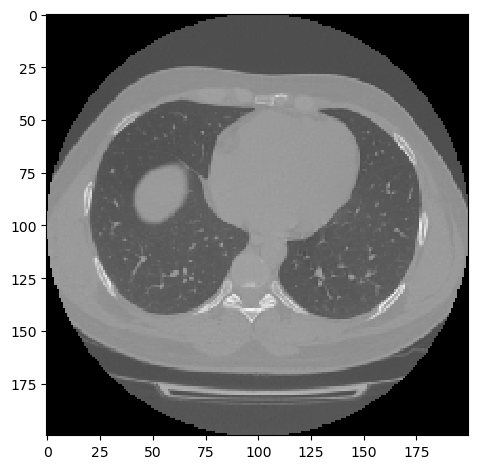

---------------Client 2 sample Image -----------------


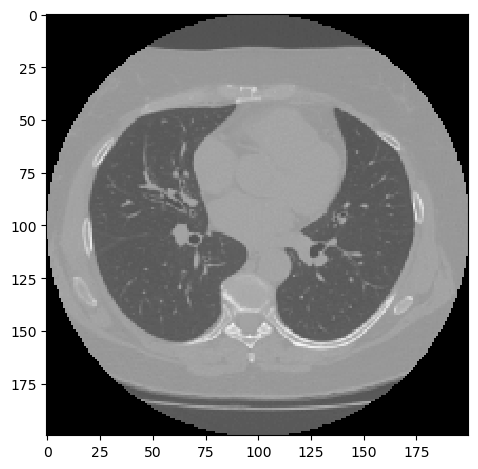

---------------Client 3 sample Image -----------------


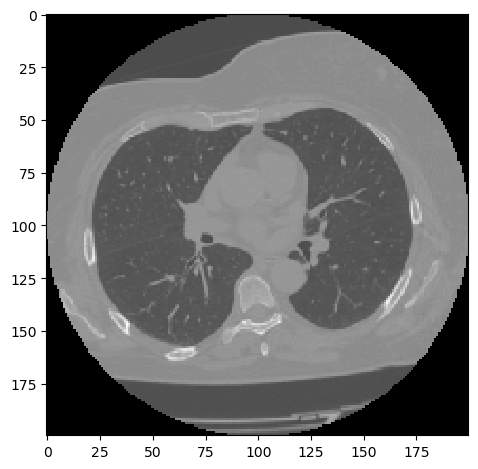

In [ ]:
print('---------------Client 1 sample Image -----------------')
imshow(train_features_dataset1_fed_iid[100])
show()
print('---------------Client 2 sample Image -----------------')
imshow(train_features_dataset2_fed_iid[0])
show()
print('---------------Client 3 sample Image -----------------')
imshow(train_features_dataset3_fed_iid[0])
show()

Mean Pixel Value: 0.27787371095938374
Variance of Pixel Values: 0.0582723553891214
Standard Deviation of Pixel Values: 0.24139667642517657


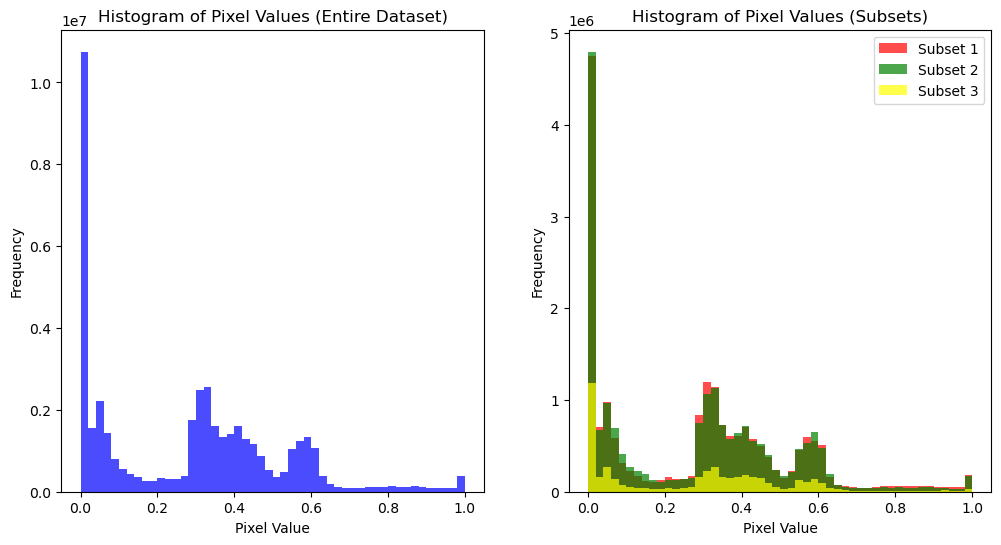

Mean Pixel Value: 0.27760929562014075
Variance of Pixel Values: 0.056485812467578035
Standard Deviation of Pixel Values: 0.2376674409076221


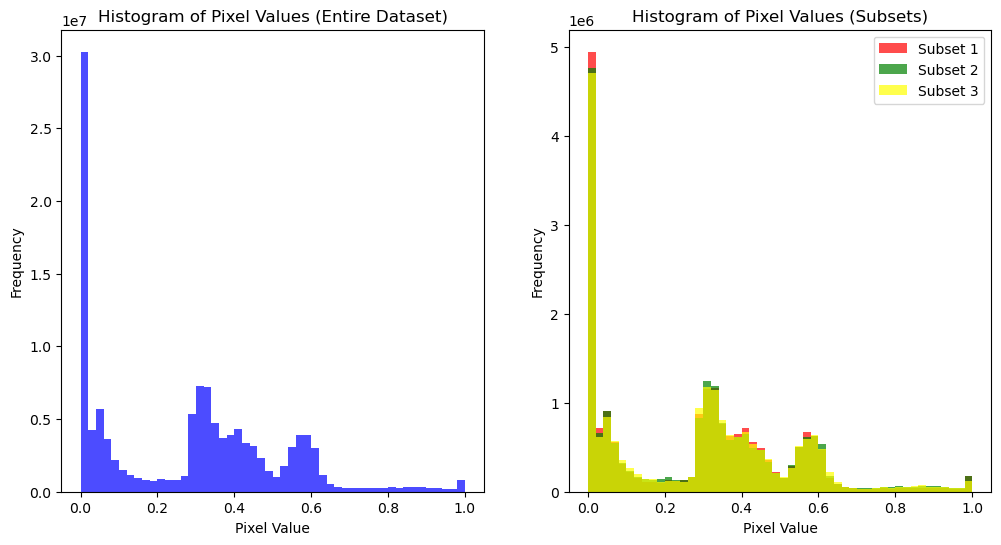

Mean Pixel Value: 0.2768275683345227
Variance of Pixel Values: 0.05673954491991269
Standard Deviation of Pixel Values: 0.23820064004933464


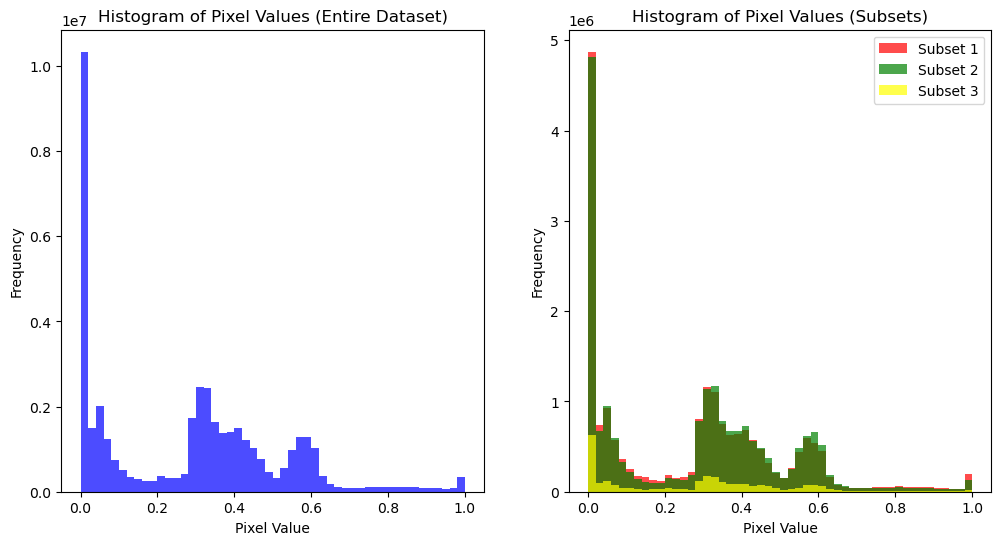

In [ ]:
dataset_pixel_stat(train_features_dataset1_fed_iid)
dataset_pixel_stat(train_features_dataset2_fed_iid)
dataset_pixel_stat(train_features_dataset3_fed_iid)

###### iid Federated Dataset (unbalanced)

In [ ]:
client_data = [(train_features_dataset1_fed_iid, train_labels_dataset1_fed_iid),
              (train_features_dataset2_fed_iid, train_labels_dataset2_fed_iid),
              (train_features_dataset3_fed_iid, train_labels_dataset3_fed_iid)]
client_datasets = [create_tf_dataset_for_client(data) for data in client_data]
# Federated data preparation
federated_train_data_IID_unbalanced = [preprocess_dataset(dataset) for dataset in client_datasets]
print('Fedrated iid unbalanced Dataset Data type: ', type(federated_train_data_IID_unbalanced))
print('Length: ', len(federated_train_data_IID_unbalanced))

Fedrated iid unbalanced Dataset Data type:  <class 'list'>
Length:  3


In [ ]:
# def convert_types(image, label):
#     image = tf.cast(image, tf.float64)  # Convert image from uint8 to float64
#     return image,label

# # Apply the conversion to the entire dataset
# temp = federated_train_data_IID_unbalanced[0].map(convert_types)

###### iid Federated Dataset (balanced)

In [ ]:
# client_data = [(train_features_dataset1_fed_iid[0:1800,:], train_labels_dataset1_fed_iid[0:1800,:]),
#               (train_features_dataset2_fed_iid, train_labels_dataset2_fed_iid),
#               (train_features_dataset3_fed_iid, train_labels_dataset3_fed_iid)]
# client_datasets = [create_tf_dataset_for_client(data) for data in client_data]
# # Federated data preparation
# federated_train_data_IID_balanced = [preprocess_dataset(dataset) for dataset in client_datasets]
# print('Fedrated iid balanced Dataset Data type: ', type(federated_train_data_IID_balanced))
# print('Length: ', len(federated_train_data_IID_balanced))

In [ ]:
client_data = [(train_features_dataset1_fed_iid, train_labels_dataset1_fed_iid),
              (train_features_dataset2_fed_iid[0:1200,:], train_labels_dataset2_fed_iid[0:1200,:]),
              (train_features_dataset3_fed_iid, train_labels_dataset3_fed_iid)]
client_datasets = [create_tf_dataset_for_client(data) for data in client_data]
# Federated data preparation
federated_train_data_IID_balanced = [preprocess_dataset(dataset) for dataset in client_datasets]
print('Fedrated iid balanced Dataset Data type: ', type(federated_train_data_IID_balanced))
print('Length: ', len(federated_train_data_IID_balanced))

Fedrated iid balanced Dataset Data type:  <class 'list'>
Length:  3


### Federated Learning

In [ ]:
#CovidCNN Architecture
def create_covidCNN_model(num_hl, hl_list,hl_conv_activation, ol_activation, dropout_val, inputShape,filters_,kernel_size_,stride_poolSize):
    '''
    teacher_Mod(model, num_hl, hl_list,hl_conv_activation, ol_activation, dropout_val, inputShape,filters_,kernel_size_,stride_poolSize):
        model = CNN Model
        num_hl = number of hidden layers
        hl_list = list of hidden layers
        hl_activation = hidden layer activation function
        out_activation = output layer activation function
        dropout_val = Dropout value
        inputShape = shape of input layer
        filters_ = filter size of Conv layer
        kernel_size_ = size of kernel (x,x)
        strides_poolSize = strides and max_pool_szie
    '''
    assert(num_hl == len(hl_list))
    assert(num_hl == len(dropout_val))

    inputs = tf.keras.layers.Input(shape=inputShape)
    image_size_ = 200
    data_augmentation = keras.Sequential(
        [
            tf.keras.layers.Normalization(),
            tf.keras.layers.Resizing(image_size_, image_size_),
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(factor=0.02),
            tf.keras.layers.RandomZoom(
                height_factor=0.2, width_factor=0.2
            ),
        ],
        name="data_augmentation",
    )
    augmented = data_augmentation(inputs)
    #connnnvolultion layer 1 with Map-pooling
    conv_layer_1 = tf.keras.layers.Conv2D(filters = filters_,kernel_size = kernel_size_,
                        strides = stride_poolSize, activation = hl_conv_activation)(augmented)#(inputs)
    conv_layer_1_max_pool = tf.keras.layers.MaxPool2D(strides=stride_poolSize)(conv_layer_1)
    x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(conv_layer_1_max_pool)

    #connnnvolultion layer 1 with Map-pooling
    conv_layer_2 = tf.keras.layers.Conv2D(filters = filters_,kernel_size = kernel_size_,strides = stride_poolSize, activation = hl_conv_activation)(x1)
    conv_layer_2_max_pool = tf.keras.layers.MaxPool2D(strides=stride_poolSize)(conv_layer_2)
    x2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(conv_layer_2_max_pool)

    flatten_layer = tf.keras.layers.Flatten()(x2)

    dense_layers = tf.keras.layers.Dense(units = hl_list[0], activation = hl_conv_activation)(flatten_layer)
    dense_layers = tf.keras.layers.Dropout(dropout_val[0])(dense_layers)
    #dense_layers = tf.keras.layers.LayerNormalization()(dense_layers)           # Batch normalization layer

    dense_layers = tf.keras.layers.Dense(units = hl_list[1], activation = hl_conv_activation)(dense_layers)
    dense_layers = tf.keras.layers.Dropout(dropout_val[1])(dense_layers)
    #dense_layers = tf.keras.layers.LayerNormalization()(dense_layers)

    dense_layers = tf.keras.layers.Dense(units = hl_list[2], activation = hl_conv_activation)(dense_layers)
    dense_layers = tf.keras.layers.Dropout(dropout_val[2])(dense_layers)
    #dense_layers = tf.keras.layers.LayerNormalization()(dense_layers)

    dense_layers = tf.keras.layers.Dense(units = hl_list[3], activation = hl_conv_activation)(dense_layers)
    dense_layers = tf.keras.layers.Dropout(dropout_val[3])(dense_layers)
    #dense_layers = tf.keras.layers.LayerNormalization()(dense_layers)

    logits = tf.keras.layers.Dense(units = 2, activation = ol_activation)(dense_layers)

    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs,outputs=logits)
    #model = compile_model(model, 'categorical_crossentropy',0.0010621475226496656,['accuracy'])
    return model

#CNN Teacher Model wrapping as TFF model
def model_fn(initial_weights=None):#COVIDCNN_model_fn
    keras_model  = create_covidCNN_model(4, [362, 184, 78, 12],'relu','softmax',[0.00,0.35,0.0,0.00],(IMAGE_SIZE,IMAGE_SIZE,1),116,8,2)
    if initial_weights is not None:
        keras_model.set_weights(initial_weights)
    return tff.learning.models.from_keras_model(
      keras_model,
      input_spec=federated_train_data_nonIID_unbalanced[0].element_spec,
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=[tf.keras.metrics.CategoricalAccuracy()])


In [ ]:
@tf.function
def client_update(model, dataset, server_weights, client_optimizer):
    """Performs local training on the client's dataset."""
    # Initialize the client model with the current server weights.
    client_weights = model.trainable_variables
    # Assign the server weights to the client model.
    tf.nest.map_structure(lambda x, y: x.assign(y),
                        client_weights, server_weights)
    # Initialize the client optimizer.
    trainable_tensor_specs = tf.nest.map_structure(
          lambda v: tf.TensorSpec(v.shape, v.dtype), client_weights)
    optimizer_state = client_optimizer.initialize(trainable_tensor_specs)
    # Use the client_optimizer to update the local model.
    for batch in iter(dataset):
        with tf.GradientTape() as tape:
            # Compute a forward pass on the batch of data.
            outputs = model.forward_pass(batch)
        # Compute the corresponding gradient.
        grads = tape.gradient(outputs.loss, client_weights)
        # Apply the gradient using a client optimizer.
        optimizer_state, updated_weights = client_optimizer.next(
            optimizer_state, client_weights, grads)
        tf.nest.map_structure(lambda a, b: a.assign(b),
                              client_weights, updated_weights)
    # Return model deltas.
    return tf.nest.map_structure(tf.subtract, client_weights, server_weights)

In [ ]:
import attrs
from typing import Any
import functools
@attrs.define(eq=False, frozen=True)
class ServerState(object):
    trainable_weights: Any
    optimizer_state: Any

@tf.function
def server_update(server_state, mean_model_delta, server_optimizer):
    """Updates the server model weights."""
    # Use aggregated negative model delta as pseudo gradient.
    negative_weights_delta = tf.nest.map_structure(
      lambda w: -1.0 * w, mean_model_delta)
    new_optimizer_state, updated_weights = server_optimizer.next(
      server_state.optimizer_state, server_state.trainable_weights,
      negative_weights_delta)
    return tff.structure.update_struct(
      server_state,
      trainable_weights=updated_weights,
      optimizer_state=new_optimizer_state)

In [ ]:
#1. Server and client optimizer to be used.
server_optimizer = tff.learning.optimizers.build_sgdm(
    learning_rate=0.05, momentum=0.8)
client_optimizer = tff.learning.optimizers.build_sgdm(
    learning_rate=0.0001)#0.01

In [ ]:
# 2. Functions return initial state on server.
@tff.tf_computation
def server_init():
    model = model_fn()
    trainable_tensor_specs = tf.nest.map_structure(
        lambda v: tf.TensorSpec(v.shape, v.dtype), model.trainable_variables)
    optimizer_state = server_optimizer.initialize(trainable_tensor_specs)
    return ServerState(
      trainable_weights=model.trainable_variables,
      optimizer_state=optimizer_state)
@tff.federated_computation
def server_init_tff():
    return tff.federated_value(server_init(), tff.SERVER)

/tmp/ipykernel_946390/591050228.py:3: DeprecationWarning: `tff.tf_computation` is deprecated, use `tff.tensorflow.computation` instead.
  def server_init():


In [ ]:
# 3. One round of computation and communication.
server_state_type = server_init.type_signature.result
print('server_state_type:\n',
      server_state_type.formatted_representation())
trainable_weights_type = server_state_type.trainable_weights
print('trainable_weights_type:\n',
      trainable_weights_type.formatted_representation())

server_state_type:
 <
  trainable_weights=<
    float32[8,8,1,116],
    float32[116],
    float32[116],
    float32[116],
    float32[8,8,116,116],
    float32[116],
    float32[116],
    float32[116],
    float32[11600,362],
    float32[362],
    float32[362,184],
    float32[184],
    float32[184,78],
    float32[78],
    float32[78,12],
    float32[12],
    float32[12,2],
    float32[2]
  >,
  optimizer_state=<
    learning_rate=float32,
    momentum=float32,
    accumulator=<
      float32[8,8,1,116],
      float32[116],
      float32[116],
      float32[116],
      float32[8,8,116,116],
      float32[116],
      float32[116],
      float32[116],
      float32[11600,362],
      float32[362],
      float32[362,184],
      float32[184],
      float32[184,78],
      float32[78],
      float32[78,12],
      float32[12],
      float32[12,2],
      float32[2]
    >
  >
>
trainable_weights_type:
 <
  float32[8,8,1,116],
  float32[116],
  float32[116],
  float32[116],
  float32[8,8,116,116

In [ ]:
# 3-1. Wrap server and client TF blocks with `tff.tf_computation`.
@tff.tf_computation(server_state_type, trainable_weights_type)
def server_update_fn(server_state, model_delta):
    return server_update(server_state, model_delta, server_optimizer)

/tmp/ipykernel_946390/2044740559.py:2: DeprecationWarning: `tff.tf_computation` is deprecated, use `tff.tensorflow.computation` instead.
  @tff.tf_computation(server_state_type, trainable_weights_type)


In [ ]:
whimsy_model = model_fn()
tf_dataset_type = tff.SequenceType(tff.types.tensorflow_to_type(whimsy_model.input_spec))
print('tf_dataset_type:\n',
      tf_dataset_type.formatted_representation())

@tff.tf_computation(tf_dataset_type, trainable_weights_type)
def client_update_fn(dataset, server_weights):
    model = model_fn()
    return client_update(model, dataset, server_weights, client_optimizer)

tf_dataset_type:
 <
  float64[?,200,200,1],
  uint8[?,2]
>*


/tmp/ipykernel_946390/3793503675.py:6: DeprecationWarning: `tff.tf_computation` is deprecated, use `tff.tensorflow.computation` instead.
  @tff.tf_computation(tf_dataset_type, trainable_weights_type)


In [ ]:
# 3-2. Orchestration with `tff.federated_computation`.
federated_server_type = tff.FederatedType(server_state_type, tff.SERVER)
federated_dataset_type = tff.FederatedType(tf_dataset_type, tff.CLIENTS)
@tff.federated_computation(federated_server_type, federated_dataset_type)
def run_one_round(server_state, federated_dataset):
    # Server-to-client broadcast.
    server_weights_at_client = tff.federated_broadcast(
      server_state.trainable_weights)
    # Local client update.
    model_deltas = tff.federated_map(
      client_update_fn, (federated_dataset, server_weights_at_client))
    # Client-to-server upload and aggregation.
    mean_model_delta = tff.federated_mean(model_deltas)
    # Server update.
    server_state = tff.federated_map(
      server_update_fn, (server_state, mean_model_delta))
    return server_state

In [ ]:
# 4. Build the iterative process for FedAvg.
fedavg_process = tff.templates.IterativeProcess(
    initialize_fn=server_init_tff, next_fn=run_one_round)
print('type signature of `initialize`:\n',
      fedavg_process.initialize.type_signature.formatted_representation())
print('type signature of `next`:\n',
      fedavg_process.next.type_signature.formatted_representation())

type signature of `initialize`:
 ( -> <
  trainable_weights=<
    float32[8,8,1,116],
    float32[116],
    float32[116],
    float32[116],
    float32[8,8,116,116],
    float32[116],
    float32[116],
    float32[116],
    float32[11600,362],
    float32[362],
    float32[362,184],
    float32[184],
    float32[184,78],
    float32[78],
    float32[78,12],
    float32[12],
    float32[12,2],
    float32[2]
  >,
  optimizer_state=<
    learning_rate=float32,
    momentum=float32,
    accumulator=<
      float32[8,8,1,116],
      float32[116],
      float32[116],
      float32[116],
      float32[8,8,116,116],
      float32[116],
      float32[116],
      float32[116],
      float32[11600,362],
      float32[362],
      float32[362,184],
      float32[184],
      float32[184,78],
      float32[78],
      float32[78,12],
      float32[12],
      float32[12,2],
      float32[2]
    >
  >
>@SERVER)
type signature of `next`:
 (<
  server_state=<
    trainable_weights=<
      float32[8,8,1,1

### Evaluating the algorithm

https://www.tensorflow.org/federated/tutorials/custom_federated_algorithm_with_tff_optimizers#evaluating_the_algorithm

In [ ]:
def map_function(input_data, target_data):
    # Apply any necessary transformations to input_data and target_data here
    # For example, you can cast the target_data to a different dtype if needed
    target_data = tf.cast(target_data, tf.float32)
    return input_data, target_data

test_data = [(X_test_combined,y_test_combined )]
test_datasets = [create_tf_dataset_for_client(data) for data in test_data]
combined_test_data = [preprocess_dataset(dataset) for dataset in test_datasets]
combined_test_data = combined_test_data[0].map(map_function)

In [ ]:
def evaluate(server_state, dataset):
    keras_model = create_covidCNN_model(4, [362, 184, 78, 12],'relu','softmax',[0.00,0.35,0.0,0.00],(IMAGE_SIZE,IMAGE_SIZE,1),116,8,2)
    #student_model = tf.keras.models.load_model('student_CNN_model.h5')
    #model_student_weight = student_model.get_weights()
    #keras_model.set_weights(model_student_weight)
    keras_model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=[tf.keras.metrics.CategoricalAccuracy()]
    )
    #keras_model.set_weights(server_state.trainable_weights)
    for var, new_weight in zip(keras_model.trainable_variables, server_state.trainable_weights):
        var.assign(new_weight)
    keras_model.evaluate(dataset)
    return keras_model

server_state = fedavg_process.initialize()
student_inital_model = evaluate(server_state, combined_test_data)

2024-05-29 13:59:07.153800: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 4
2024-05-29 13:59:07.153949: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-05-29 13:59:07.179942: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14826 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:19:00.0, compute capability: 7.5
2024-05-29 13:59:07.180205: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14826 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:1a:00.0, compute capability: 7.5
2024-05-29 13:59:07.180423: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14826 MB memory:  -> device: 2, name: Quadro RTX 5000, pci bus id: 0000:67:00.0, compute c

67/67 [==============================] - 5s 68ms/step - loss: 0.8140 - categorical_accuracy: 0.5151


9/9 [==============================] - 1s 102ms/step


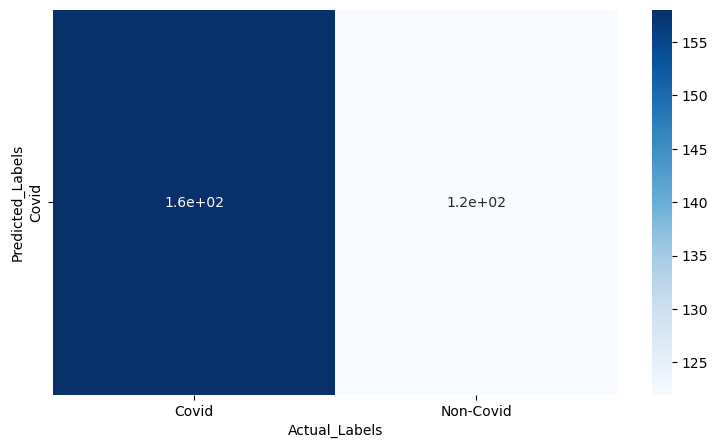

test accuracy = 56.42857142857143%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.5643
Precision: 0.3184
Recall: 0.5643
F1 Score: 0.4071


/home/rkannan/miniconda3/envs/richard_tf_fedLearning/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


25/25 [==============================] - 2s 75ms/step


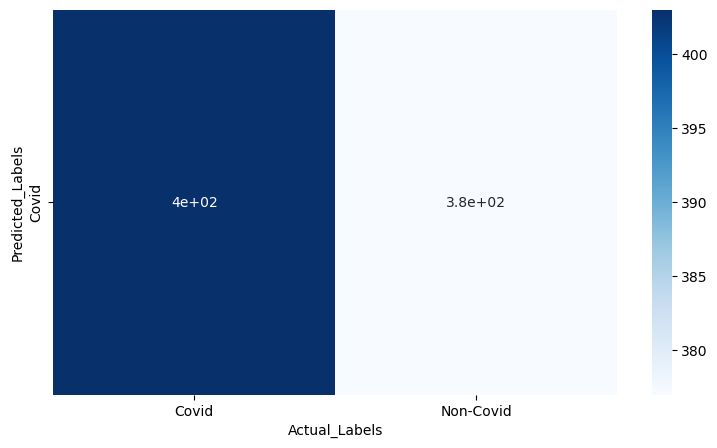

test accuracy = 51.66666666666667%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.5167
Precision: 0.2669
Recall: 0.5167
F1 Score: 0.352


/home/rkannan/miniconda3/envs/richard_tf_fedLearning/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 1s 63ms/step


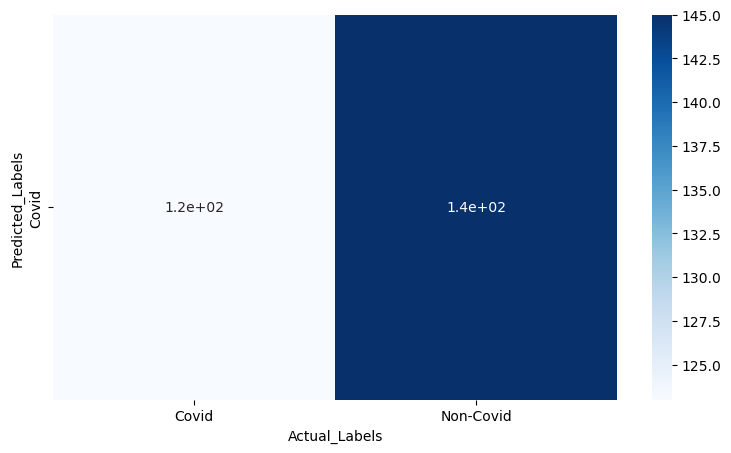

test accuracy = 45.8955223880597%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.459
Precision: 0.2106
Recall: 0.459
F1 Score: 0.2888


/home/rkannan/miniconda3/envs/richard_tf_fedLearning/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# X_test_combined = np.concatenate((test_features_dataset1_fed, test_features_dataset2_fed,
#                                   test_features_dataset3_fed), axis=0)
# y_test_combined = np.concatenate((test_labels_dataset1_fed, test_labels_dataset2_fed,
#                                   test_labels_dataset3_fed), axis=0)
getModelEvaluation(student_inital_model,test_features_dataset1_fed,test_labels_dataset1_fed)
getModelEvaluation(student_inital_model,test_features_dataset2_fed,test_labels_dataset2_fed)
getModelEvaluation(student_inital_model,test_features_dataset3_fed,test_labels_dataset3_fed)

In [ ]:
metrics = {'loss':[],'accuracy':[]}

## FedAvg StudentMod_only Experiments

- federated_train_data_nonIID_unbalanced
- federated_train_data_nonIID_balanced
- federated_train_data_IID_unbalanced
- federated_train_data_IID_balanced

### federated_train_data_nonIID_unbalanced

In [ ]:
from tqdm import tqdm
import time
for round in tqdm(range(50)):
    server_state = fedavg_process.next(server_state, federated_train_data_nonIID_unbalanced)
    FL_CovidCNN_model = evaluate(server_state,combined_test_data)
    loss = list(FL_CovidCNN_model.get_metrics_result().values())[0].numpy()
    accuracy = list(FL_CovidCNN_model.get_metrics_result().values())[1].numpy()
    metrics['loss'].append(loss)
    metrics['accuracy'].append(accuracy)

  0%|                                                    | 0/50 [00:00<?, ?it/s]2024-05-29 13:59:18.652781: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 4
2024-05-29 13:59:18.652884: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-05-29 13:59:18.656469: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14826 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:19:00.0, compute capability: 7.5
2024-05-29 13:59:18.656677: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14826 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:1a:00.0, compute capability: 7.5
2024-05-29 13:59:18.656882: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14826 MB m

2024-05-29 13:59:19.841765: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 4
2024-05-29 13:59:19.841869: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-05-29 13:59:19.846442: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14826 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:19:00.0, compute capability: 7.5
2024-05-29 13:59:19.846720: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14826 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:1a:00.0, compute capability: 7.5
2024-05-29 13:59:19.846994: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14826 MB memory:  -> device: 2, name: Quadro RTX 5000, pci bus id: 0000:67:00.0, compute c

67/67 [==============================] - 7s 92ms/step - loss: 0.7198 - categorical_accuracy: 0.5151


  2%|▊                                         | 1/50 [01:14<1:01:03, 74.77s/it]

67/67 [==============================] - 5s 70ms/step - loss: 0.6844 - categorical_accuracy: 0.5196


  4%|█▋                                        | 2/50 [02:44<1:06:41, 83.37s/it]

67/67 [==============================] - 3s 42ms/step - loss: 0.6843 - categorical_accuracy: 0.5866


  6%|██▋                                         | 3/50 [03:49<58:56, 75.25s/it]

67/67 [==============================] - 5s 67ms/step - loss: 0.6986 - categorical_accuracy: 0.5053


  8%|███▎                                      | 4/50 [05:20<1:02:30, 81.54s/it]

67/67 [==============================] - 5s 68ms/step - loss: 0.7099 - categorical_accuracy: 0.4880


 10%|████▏                                     | 5/50 [06:38<1:00:00, 80.00s/it]

67/67 [==============================] - 7s 92ms/step - loss: 0.7059 - categorical_accuracy: 0.4872


 12%|█████                                     | 6/50 [08:07<1:01:01, 83.23s/it]

67/67 [==============================] - 5s 66ms/step - loss: 0.6989 - categorical_accuracy: 0.4864


 14%|██████▏                                     | 7/50 [09:30<59:37, 83.21s/it]

67/67 [==============================] - 7s 92ms/step - loss: 0.6919 - categorical_accuracy: 0.5015


 16%|███████                                     | 8/50 [10:52<57:48, 82.58s/it]

67/67 [==============================] - 4s 57ms/step - loss: 0.6874 - categorical_accuracy: 0.5286


 18%|███████▉                                    | 9/50 [12:16<56:50, 83.18s/it]

67/67 [==============================] - 7s 93ms/step - loss: 0.6815 - categorical_accuracy: 0.5753


 20%|████████▌                                  | 10/50 [13:27<53:00, 79.51s/it]

67/67 [==============================] - 5s 68ms/step - loss: 0.6752 - categorical_accuracy: 0.6242


 22%|█████████▍                                 | 11/50 [14:57<53:39, 82.56s/it]

67/67 [==============================] - 3s 41ms/step - loss: 0.6692 - categorical_accuracy: 0.6446


 24%|██████████▎                                | 12/50 [16:03<49:11, 77.66s/it]

67/67 [==============================] - 5s 69ms/step - loss: 0.6649 - categorical_accuracy: 0.6589


 26%|███████████▏                               | 13/50 [17:35<50:29, 81.87s/it]

67/67 [==============================] - 3s 42ms/step - loss: 0.6597 - categorical_accuracy: 0.6702


 28%|████████████                               | 14/50 [18:52<48:15, 80.44s/it]

67/67 [==============================] - 6s 85ms/step - loss: 0.6545 - categorical_accuracy: 0.6634


 30%|████████████▉                              | 15/50 [20:24<48:53, 83.82s/it]

67/67 [==============================] - 5s 67ms/step - loss: 0.6503 - categorical_accuracy: 0.6596


 32%|█████████████▊                             | 16/50 [21:44<46:53, 82.75s/it]

67/67 [==============================] - 6s 90ms/step - loss: 0.6464 - categorical_accuracy: 0.6566


 34%|██████████████▌                            | 17/50 [23:14<46:38, 84.81s/it]

67/67 [==============================] - 5s 68ms/step - loss: 0.6433 - categorical_accuracy: 0.6551


 36%|███████████████▍                           | 18/50 [24:36<44:53, 84.19s/it]

67/67 [==============================] - 6s 90ms/step - loss: 0.6416 - categorical_accuracy: 0.6514


 38%|████████████████▎                          | 19/50 [26:02<43:40, 84.54s/it]

67/67 [==============================] - 5s 67ms/step - loss: 0.6409 - categorical_accuracy: 0.6551


 40%|█████████████████▏                         | 20/50 [27:24<41:59, 83.98s/it]

67/67 [==============================] - 7s 92ms/step - loss: 0.6403 - categorical_accuracy: 0.6566


 42%|██████████████████                         | 21/50 [28:39<39:15, 81.21s/it]

67/67 [==============================] - 5s 66ms/step - loss: 0.6416 - categorical_accuracy: 0.6627


 44%|██████████████████▉                        | 22/50 [30:05<38:36, 82.75s/it]

67/67 [==============================] - 3s 41ms/step - loss: 0.6440 - categorical_accuracy: 0.6596


 46%|███████████████████▊                       | 23/50 [31:09<34:40, 77.05s/it]

67/67 [==============================] - 5s 65ms/step - loss: 0.6471 - categorical_accuracy: 0.6634


 48%|████████████████████▋                      | 24/50 [32:42<35:23, 81.67s/it]

67/67 [==============================] - 3s 42ms/step - loss: 0.6497 - categorical_accuracy: 0.6649


 50%|█████████████████████▌                     | 25/50 [33:54<32:48, 78.74s/it]

67/67 [==============================] - 5s 70ms/step - loss: 0.6527 - categorical_accuracy: 0.6664


 52%|██████████████████████▎                    | 26/50 [35:26<33:10, 82.93s/it]

67/67 [==============================] - 3s 41ms/step - loss: 0.6540 - categorical_accuracy: 0.6672


 54%|███████████████████████▏                   | 27/50 [36:45<31:20, 81.77s/it]

67/67 [==============================] - 6s 80ms/step - loss: 0.6540 - categorical_accuracy: 0.6679


 56%|████████████████████████                   | 28/50 [38:16<30:57, 84.42s/it]

67/67 [==============================] - 5s 67ms/step - loss: 0.6550 - categorical_accuracy: 0.6649


 58%|████████████████████████▉                  | 29/50 [39:36<29:04, 83.06s/it]

67/67 [==============================] - 6s 91ms/step - loss: 0.6548 - categorical_accuracy: 0.6657


 60%|█████████████████████████▊                 | 30/50 [41:02<27:58, 83.90s/it]

67/67 [==============================] - 5s 68ms/step - loss: 0.6539 - categorical_accuracy: 0.6657


 62%|██████████████████████████▋                | 31/50 [42:24<26:26, 83.50s/it]

67/67 [==============================] - 6s 90ms/step - loss: 0.6524 - categorical_accuracy: 0.6679


 64%|███████████████████████████▌               | 32/50 [43:40<24:22, 81.22s/it]

67/67 [==============================] - 5s 68ms/step - loss: 0.6502 - categorical_accuracy: 0.6657


 66%|████████████████████████████▍              | 33/50 [45:07<23:27, 82.78s/it]

67/67 [==============================] - 3s 43ms/step - loss: 0.6491 - categorical_accuracy: 0.6657


 68%|█████████████████████████████▏             | 34/50 [46:11<20:36, 77.28s/it]

67/67 [==============================] - 5s 74ms/step - loss: 0.6490 - categorical_accuracy: 0.6649


 70%|██████████████████████████████             | 35/50 [47:44<20:29, 81.96s/it]

67/67 [==============================] - 3s 41ms/step - loss: 0.6492 - categorical_accuracy: 0.6687


 72%|██████████████████████████████▉            | 36/50 [48:58<18:36, 79.72s/it]

67/67 [==============================] - 3s 45ms/step - loss: 0.6484 - categorical_accuracy: 0.6687


 74%|███████████████████████████████▊           | 37/50 [50:03<16:18, 75.31s/it]

67/67 [==============================] - 5s 70ms/step - loss: 0.6478 - categorical_accuracy: 0.6672


 76%|████████████████████████████████▋          | 38/50 [51:53<17:05, 85.50s/it]

67/67 [==============================] - 4s 55ms/step - loss: 0.6479 - categorical_accuracy: 0.6694


 78%|█████████████████████████████████▌         | 39/50 [53:23<15:55, 86.88s/it]

67/67 [==============================] - 7s 91ms/step - loss: 0.6487 - categorical_accuracy: 0.6724


 80%|██████████████████████████████████▍        | 40/50 [54:34<13:40, 82.10s/it]

67/67 [==============================] - 5s 71ms/step - loss: 0.6472 - categorical_accuracy: 0.6717


 82%|███████████████████████████████████▎       | 41/50 [56:19<13:22, 89.19s/it]

67/67 [==============================] - 3s 48ms/step - loss: 0.6434 - categorical_accuracy: 0.6717


 84%|████████████████████████████████████       | 42/50 [57:48<11:52, 89.06s/it]

67/67 [==============================] - 8s 105ms/step - loss: 0.6393 - categorical_accuracy: 0.6717


 86%|████████████████████████████████████▉      | 43/50 [59:39<11:10, 95.73s/it]

67/67 [==============================] - 3s 45ms/step - loss: 0.6357 - categorical_accuracy: 0.6694


 88%|████████████████████████████████████     | 44/50 [1:01:07<09:19, 93.22s/it]

67/67 [==============================] - 5s 71ms/step - loss: 0.6314 - categorical_accuracy: 0.6694


 90%|████████████████████████████████████▉    | 45/50 [1:02:55<08:08, 97.61s/it]

67/67 [==============================] - 5s 69ms/step - loss: 0.6280 - categorical_accuracy: 0.6687


 92%|█████████████████████████████████████▋   | 46/50 [1:04:32<06:29, 97.50s/it]

67/67 [==============================] - 6s 88ms/step - loss: 0.6261 - categorical_accuracy: 0.6717


 94%|██████████████████████████████████████▌  | 47/50 [1:06:16<04:58, 99.44s/it]

67/67 [==============================] - 8s 115ms/step - loss: 0.6252 - categorical_accuracy: 0.6732


 96%|███████████████████████████████████████▎ | 48/50 [1:07:51<03:16, 98.02s/it]

67/67 [==============================] - 7s 95ms/step - loss: 0.6247 - categorical_accuracy: 0.6739


 98%|████████████████████████████████████████▏| 49/50 [1:09:24<01:36, 96.66s/it]

67/67 [==============================] - 4s 51ms/step - loss: 0.6235 - categorical_accuracy: 0.6739


100%|█████████████████████████████████████████| 50/50 [1:11:03<00:00, 85.26s/it]


--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------
42/42 [==============================] - 6s 105ms/step


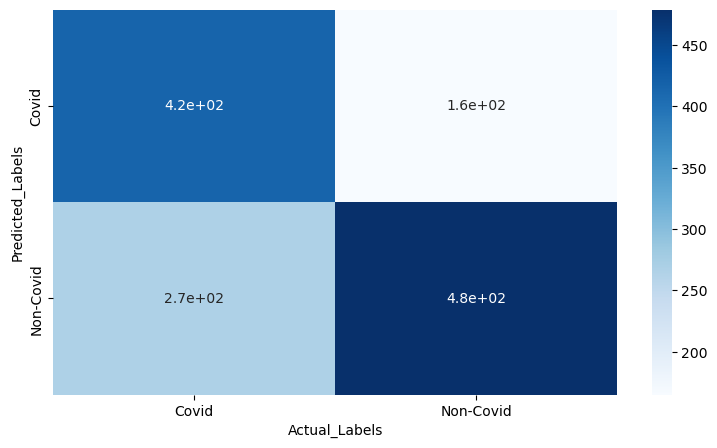

test accuracy = 67.39457831325302%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.6739
Precision: 0.6797
Recall: 0.6739
F1 Score: 0.6727


In [ ]:
print('--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------')
getModelEvaluation(FL_CovidCNN_model,X_test_combined,y_test_combined)

In [ ]:
FL_CovidCNN_model.save('gsm_noniid_unbalanced.h5')

/home/rkannan/miniconda3/envs/richard_tf_fedLearning/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


--------------------- Student Model Evaluation on Dataset1 ------------------------
9/9 [==============================] - 1s 99ms/step


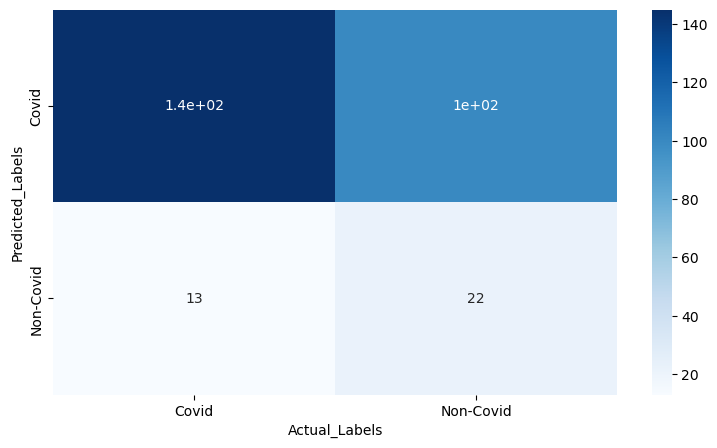

test accuracy = 59.64285714285714%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.5964
Precision: 0.6078
Recall: 0.5964
F1 Score: 0.5282
--------------------- Student Model Evaluation on Dataset2 ------------------------
25/25 [==============================] - 3s 105ms/step


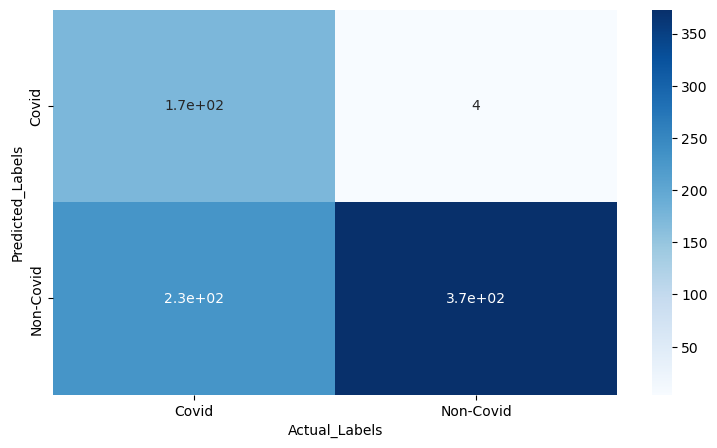

test accuracy = 70.0%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.7
Precision: 0.804
Recall: 0.7
F1 Score: 0.6761
--------------------- Student Model Evaluation on Dataset3 ------------------------
9/9 [==============================] - 1s 99ms/step


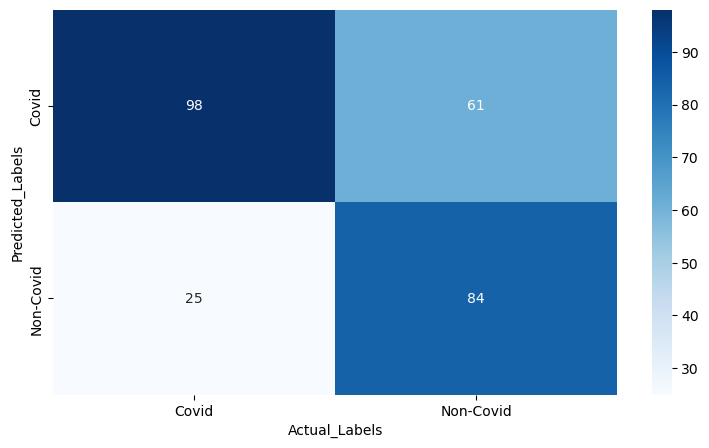

test accuracy = 67.91044776119402%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.6791
Precision: 0.6998
Recall: 0.6791
F1 Score: 0.6768


In [ ]:
print('--------------------- Student Model Evaluation on Dataset1 ------------------------')
getModelEvaluation(FL_CovidCNN_model,test_features_dataset1_fed,test_labels_dataset1_fed)
print('--------------------- Student Model Evaluation on Dataset2 ------------------------')
getModelEvaluation(FL_CovidCNN_model,test_features_dataset2_fed,test_labels_dataset2_fed)
print('--------------------- Student Model Evaluation on Dataset3 ------------------------')
getModelEvaluation(FL_CovidCNN_model,test_features_dataset3_fed,test_labels_dataset3_fed)

### federated_train_data_nonIID_balanced

In [ ]:
server_state = fedavg_process.initialize()
for round in tqdm(range(50)):
    server_state = fedavg_process.next(server_state, federated_train_data_nonIID_balanced)
    FL_CovidCNN_model = evaluate(server_state,combined_test_data)
    loss = list(FL_CovidCNN_model.get_metrics_result().values())[0].numpy()
    accuracy = list(FL_CovidCNN_model.get_metrics_result().values())[1].numpy()
    metrics['loss'].append(loss)
    metrics['accuracy'].append(accuracy)

  0%|                                                    | 0/50 [00:00<?, ?it/s]

67/67 [==============================] - 3s 44ms/step - loss: 0.6911 - categorical_accuracy: 0.5196


  2%|▉                                           | 1/50 [00:48<39:37, 48.52s/it]

67/67 [==============================] - 9s 130ms/step - loss: 0.6760 - categorical_accuracy: 0.6265


  4%|█▊                                          | 2/50 [02:04<51:48, 64.75s/it]

67/67 [==============================] - 6s 81ms/step - loss: 0.6819 - categorical_accuracy: 0.5369


  6%|██▋                                         | 3/50 [03:09<50:42, 64.74s/it]

67/67 [==============================] - 3s 43ms/step - loss: 0.6910 - categorical_accuracy: 0.4940


  8%|███▌                                        | 4/50 [04:10<48:25, 63.15s/it]

67/67 [==============================] - 6s 87ms/step - loss: 0.7010 - categorical_accuracy: 0.4857


 10%|████▍                                       | 5/50 [05:20<49:26, 65.91s/it]

67/67 [==============================] - 5s 71ms/step - loss: 0.7110 - categorical_accuracy: 0.4849


 12%|█████▎                                      | 6/50 [06:25<48:00, 65.46s/it]

67/67 [==============================] - 5s 70ms/step - loss: 0.7161 - categorical_accuracy: 0.4849


 14%|██████▏                                     | 7/50 [07:24<45:22, 63.32s/it]

67/67 [==============================] - 3s 42ms/step - loss: 0.7114 - categorical_accuracy: 0.4842


 16%|███████                                     | 8/50 [08:10<40:35, 58.00s/it]

67/67 [==============================] - 9s 126ms/step - loss: 0.7031 - categorical_accuracy: 0.4842


 18%|███████▉                                    | 9/50 [09:13<40:37, 59.44s/it]

67/67 [==============================] - 5s 73ms/step - loss: 0.6980 - categorical_accuracy: 0.4849


 20%|████████▌                                  | 10/50 [10:25<42:09, 63.25s/it]

67/67 [==============================] - 5s 71ms/step - loss: 0.6957 - categorical_accuracy: 0.5008


 22%|█████████▍                                 | 11/50 [11:29<41:15, 63.47s/it]

67/67 [==============================] - 5s 77ms/step - loss: 0.6964 - categorical_accuracy: 0.5407


 24%|██████████▎                                | 12/50 [12:23<38:26, 60.69s/it]

67/67 [==============================] - 5s 71ms/step - loss: 0.6965 - categorical_accuracy: 0.5437


 26%|███████████▏                               | 13/50 [13:39<40:10, 65.15s/it]

67/67 [==============================] - 5s 70ms/step - loss: 0.6960 - categorical_accuracy: 0.4405


 28%|████████████                               | 14/50 [14:38<38:00, 63.34s/it]

67/67 [==============================] - 3s 43ms/step - loss: 0.6950 - categorical_accuracy: 0.4172


 30%|████████████▉                              | 15/50 [15:31<35:06, 60.19s/it]

67/67 [==============================] - 8s 110ms/step - loss: 0.6936 - categorical_accuracy: 0.4360


 32%|█████████████▊                             | 16/50 [16:41<35:52, 63.31s/it]

67/67 [==============================] - 7s 97ms/step - loss: 0.6918 - categorical_accuracy: 0.4684


 34%|██████████████▌                            | 17/50 [17:50<35:41, 64.89s/it]

67/67 [==============================] - 6s 83ms/step - loss: 0.6899 - categorical_accuracy: 0.5196


 36%|███████████████▍                           | 18/50 [18:54<34:31, 64.72s/it]

67/67 [==============================] - 6s 89ms/step - loss: 0.6884 - categorical_accuracy: 0.5964


 38%|████████████████▎                          | 19/50 [19:53<32:33, 63.00s/it]

67/67 [==============================] - 5s 70ms/step - loss: 0.6875 - categorical_accuracy: 0.6250


 40%|█████████████████▏                         | 20/50 [21:05<32:49, 65.66s/it]

67/67 [==============================] - 5s 71ms/step - loss: 0.6869 - categorical_accuracy: 0.6258


 42%|██████████████████                         | 21/50 [22:05<30:57, 64.06s/it]

67/67 [==============================] - 3s 44ms/step - loss: 0.6864 - categorical_accuracy: 0.6235


 44%|██████████████████▉                        | 22/50 [22:54<27:48, 59.59s/it]

67/67 [==============================] - 9s 123ms/step - loss: 0.6864 - categorical_accuracy: 0.6205


 46%|███████████████████▊                       | 23/50 [24:08<28:40, 63.72s/it]

67/67 [==============================] - 5s 70ms/step - loss: 0.6871 - categorical_accuracy: 0.6235


 48%|████████████████████▋                      | 24/50 [25:12<27:42, 63.93s/it]

67/67 [==============================] - 3s 46ms/step - loss: 0.6888 - categorical_accuracy: 0.6250


 50%|█████████████████████▌                     | 25/50 [26:15<26:26, 63.47s/it]

67/67 [==============================] - 9s 122ms/step - loss: 0.6869 - categorical_accuracy: 0.6258


 52%|██████████████████████▎                    | 26/50 [27:17<25:14, 63.10s/it]

67/67 [==============================] - 5s 71ms/step - loss: 0.6848 - categorical_accuracy: 0.6310


 54%|███████████████████████▏                   | 27/50 [28:26<24:52, 64.91s/it]

67/67 [==============================] - 5s 70ms/step - loss: 0.6834 - categorical_accuracy: 0.6333


 56%|████████████████████████                   | 28/50 [29:28<23:30, 64.13s/it]

67/67 [==============================] - 3s 44ms/step - loss: 0.6842 - categorical_accuracy: 0.6378


 58%|████████████████████████▉                  | 29/50 [30:17<20:48, 59.44s/it]

67/67 [==============================] - 6s 90ms/step - loss: 0.6840 - categorical_accuracy: 0.6393


 60%|█████████████████████████▊                 | 30/50 [31:38<22:00, 66.05s/it]

67/67 [==============================] - 5s 73ms/step - loss: 0.6826 - categorical_accuracy: 0.6370


 62%|██████████████████████████▋                | 31/50 [32:42<20:42, 65.39s/it]

67/67 [==============================] - 3s 43ms/step - loss: 0.6806 - categorical_accuracy: 0.6408


 64%|███████████████████████████▌               | 32/50 [33:35<18:31, 61.73s/it]

67/67 [==============================] - 6s 87ms/step - loss: 0.6780 - categorical_accuracy: 0.6431


 66%|████████████████████████████▍              | 33/50 [34:47<18:22, 64.84s/it]

67/67 [==============================] - 5s 70ms/step - loss: 0.6745 - categorical_accuracy: 0.6438


 68%|█████████████████████████████▏             | 34/50 [35:55<17:31, 65.73s/it]

67/67 [==============================] - 5s 77ms/step - loss: 0.6712 - categorical_accuracy: 0.6461


 70%|██████████████████████████████             | 35/50 [36:59<16:16, 65.11s/it]

67/67 [==============================] - 6s 87ms/step - loss: 0.6683 - categorical_accuracy: 0.6468


 72%|██████████████████████████████▉            | 36/50 [37:56<14:40, 62.87s/it]

67/67 [==============================] - 5s 71ms/step - loss: 0.6659 - categorical_accuracy: 0.6453


 74%|███████████████████████████████▊           | 37/50 [39:09<14:16, 65.89s/it]

67/67 [==============================] - 7s 102ms/step - loss: 0.6666 - categorical_accuracy: 0.6491


 76%|████████████████████████████████▋          | 38/50 [40:09<12:48, 64.07s/it]

67/67 [==============================] - 3s 44ms/step - loss: 0.6665 - categorical_accuracy: 0.6491


 78%|█████████████████████████████████▌         | 39/50 [41:00<11:01, 60.17s/it]

67/67 [==============================] - 7s 101ms/step - loss: 0.6674 - categorical_accuracy: 0.6476


 80%|██████████████████████████████████▍        | 40/50 [42:16<10:47, 64.79s/it]

67/67 [==============================] - 5s 71ms/step - loss: 0.6629 - categorical_accuracy: 0.6498


 82%|███████████████████████████████████▎       | 41/50 [43:17<09:33, 63.74s/it]

67/67 [==============================] - 3s 43ms/step - loss: 0.6583 - categorical_accuracy: 0.6529


 84%|████████████████████████████████████       | 42/50 [44:17<08:19, 62.44s/it]

67/67 [==============================] - 8s 108ms/step - loss: 0.6546 - categorical_accuracy: 0.6544


 86%|████████████████████████████████████▉      | 43/50 [45:22<07:23, 63.36s/it]

67/67 [==============================] - 5s 71ms/step - loss: 0.6525 - categorical_accuracy: 0.6574


 88%|█████████████████████████████████████▊     | 44/50 [46:31<06:29, 64.92s/it]

67/67 [==============================] - 5s 70ms/step - loss: 0.6506 - categorical_accuracy: 0.6574


 90%|██████████████████████████████████████▋    | 45/50 [47:34<05:22, 64.51s/it]

67/67 [==============================] - 8s 121ms/step - loss: 0.6482 - categorical_accuracy: 0.6574


 92%|███████████████████████████████████████▌   | 46/50 [48:26<04:02, 60.65s/it]

67/67 [==============================] - 5s 70ms/step - loss: 0.6468 - categorical_accuracy: 0.6589


 94%|████████████████████████████████████████▍  | 47/50 [49:40<03:14, 64.84s/it]

67/67 [==============================] - 4s 61ms/step - loss: 0.6457 - categorical_accuracy: 0.6589


 96%|█████████████████████████████████████████▎ | 48/50 [50:44<02:08, 64.36s/it]

67/67 [==============================] - 4s 45ms/step - loss: 0.6436 - categorical_accuracy: 0.6619


 98%|██████████████████████████████████████████▏| 49/50 [51:34<01:00, 60.20s/it]

67/67 [==============================] - 6s 90ms/step - loss: 0.6442 - categorical_accuracy: 0.6611


100%|███████████████████████████████████████████| 50/50 [52:44<00:00, 63.29s/it]


--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------
42/42 [==============================] - 6s 136ms/step


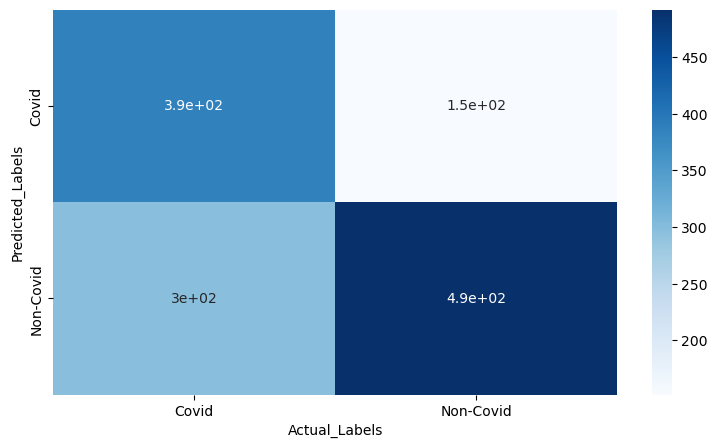

test accuracy = 66.1144578313253%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.6611
Precision: 0.6716
Recall: 0.6611
F1 Score: 0.6582


In [ ]:
print('--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------')
getModelEvaluation(FL_CovidCNN_model,X_test_combined,y_test_combined)

--------------------- Student Model Evaluation on Dataset1 ------------------------
9/9 [==============================] - 2s 198ms/step


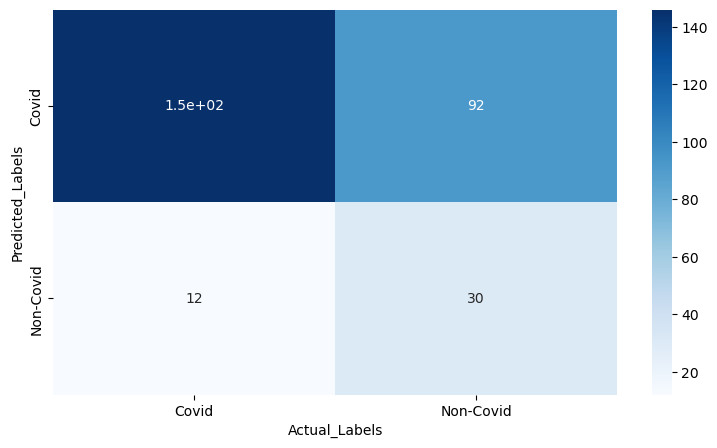

test accuracy = 62.857142857142854%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.6286
Precision: 0.6574
Recall: 0.6286
F1 Score: 0.5755
--------------------- Student Model Evaluation on Dataset2 ------------------------
25/25 [==============================] - 4s 143ms/step


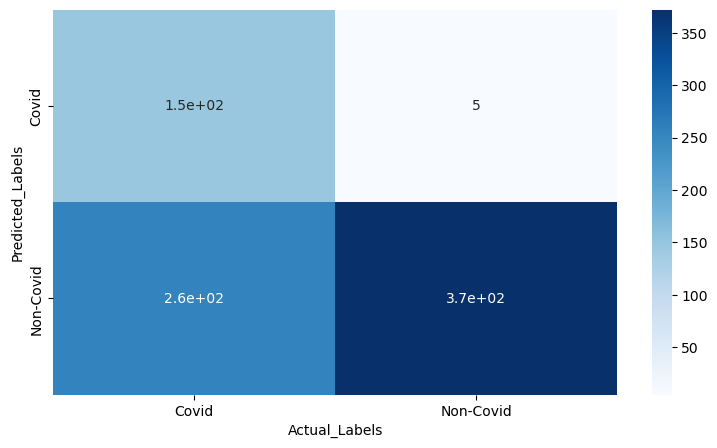

test accuracy = 66.66666666666666%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.6667
Precision: 0.7865
Recall: 0.6667
F1 Score: 0.6332
--------------------- Student Model Evaluation on Dataset3 ------------------------
9/9 [==============================] - 1s 137ms/step


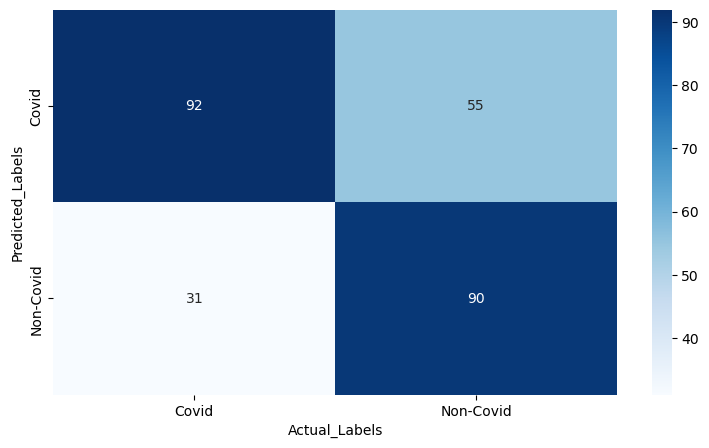

test accuracy = 67.91044776119402%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.6791
Precision: 0.6897
Recall: 0.6791
F1 Score: 0.6789


In [ ]:
print('--------------------- Student Model Evaluation on Dataset1 ------------------------')
getModelEvaluation(FL_CovidCNN_model,test_features_dataset1_fed,test_labels_dataset1_fed)
print('--------------------- Student Model Evaluation on Dataset2 ------------------------')
getModelEvaluation(FL_CovidCNN_model,test_features_dataset2_fed,test_labels_dataset2_fed)
print('--------------------- Student Model Evaluation on Dataset3 ------------------------')
getModelEvaluation(FL_CovidCNN_model,test_features_dataset3_fed,test_labels_dataset3_fed)

In [ ]:
FL_CovidCNN_model.save('gsm_noniid_balanced.h5')

/home/rkannan/miniconda3/envs/richard_tf_fedLearning/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### federated_train_data_IID_unbalanced

In [ ]:
X_test_combined_iid = np.concatenate((test_features_dataset1_fed_iid, test_features_dataset2_fed_iid,
                                  test_features_dataset3_fed_iid), axis=0)
y_test_combined_iid = np.concatenate((test_labels_dataset1_fed_iid, test_labels_dataset2_fed_iid,
                                  test_labels_dataset3_fed_iid), axis=0)
test_data_iid = [(X_test_combined_iid,y_test_combined_iid )]
test_datasets_iid = [create_tf_dataset_for_client(data) for data in test_data_iid]
combined_test_data_iid = [preprocess_dataset(dataset) for dataset in test_datasets_iid]
combined_test_data_iid = combined_test_data_iid[0].map(map_function)

In [ ]:
# test_data_iid = [(X_test_combined_iid,y_test_combined_iid)]
# test_datasets_iid = [create_tf_dataset_for_client(data) for data in test_data_iid]
# combined_test_data_iid = [preprocess_dataset(dataset) for dataset in test_datasets_iid]
# combined_test_data_iid = combined_test_data_iid[0].map(map_function)

In [ ]:
server_state = fedavg_process.initialize()
for round in tqdm(range(50)):
    server_state = fedavg_process.next(server_state, federated_train_data_IID_unbalanced)
    FL_CovidCNN_model = evaluate(server_state,combined_test_data_iid)
    loss = list(FL_CovidCNN_model.get_metrics_result().values())[0].numpy()
    accuracy = list(FL_CovidCNN_model.get_metrics_result().values())[1].numpy()
    metrics['loss'].append(loss)
    metrics['accuracy'].append(accuracy)

  0%|                                                    | 0/50 [00:00<?, ?it/s]

67/67 [==============================] - 5s 72ms/step - loss: 0.6582 - categorical_accuracy: 0.5497


  2%|▊                                         | 1/50 [01:34<1:16:52, 94.14s/it]

67/67 [==============================] - 7s 102ms/step - loss: 0.6601 - categorical_accuracy: 0.7086


  4%|█▋                                        | 2/50 [03:11<1:16:51, 96.07s/it]

67/67 [==============================] - 5s 70ms/step - loss: 0.6490 - categorical_accuracy: 0.6943


  6%|██▌                                       | 3/50 [04:47<1:15:09, 95.94s/it]

67/67 [==============================] - 7s 99ms/step - loss: 0.6560 - categorical_accuracy: 0.5761


  8%|███▎                                      | 4/50 [06:15<1:11:10, 92.83s/it]

67/67 [==============================] - 8s 114ms/step - loss: 0.6772 - categorical_accuracy: 0.5211


 10%|████▏                                     | 5/50 [07:59<1:12:45, 97.00s/it]

67/67 [==============================] - 3s 45ms/step - loss: 0.6935 - categorical_accuracy: 0.4895


 12%|█████                                     | 6/50 [09:18<1:06:32, 90.73s/it]

67/67 [==============================] - 5s 72ms/step - loss: 0.6916 - categorical_accuracy: 0.5098


 14%|█████▉                                    | 7/50 [11:07<1:09:22, 96.81s/it]

67/67 [==============================] - 6s 94ms/step - loss: 0.6833 - categorical_accuracy: 0.5301


 16%|██████▋                                   | 8/50 [12:35<1:05:49, 94.04s/it]

67/67 [==============================] - 7s 91ms/step - loss: 0.6666 - categorical_accuracy: 0.5798


 18%|███████▌                                  | 9/50 [13:55<1:01:15, 89.65s/it]

67/67 [==============================] - 5s 70ms/step - loss: 0.6455 - categorical_accuracy: 0.6084


 20%|████████▏                                | 10/50 [15:39<1:02:43, 94.10s/it]

67/67 [==============================] - 5s 77ms/step - loss: 0.6242 - categorical_accuracy: 0.6348


 22%|█████████▍                                 | 11/50 [16:59<58:17, 89.68s/it]

67/67 [==============================] - 7s 104ms/step - loss: 0.6034 - categorical_accuracy: 0.6770


 24%|█████████▊                               | 12/50 [18:49<1:00:36, 95.71s/it]

67/67 [==============================] - 3s 44ms/step - loss: 0.5864 - categorical_accuracy: 0.6973


 26%|███████████▏                               | 13/50 [20:15<57:15, 92.84s/it]

67/67 [==============================] - 5s 71ms/step - loss: 0.5729 - categorical_accuracy: 0.7108


 28%|████████████                               | 14/50 [22:04<58:41, 97.81s/it]

67/67 [==============================] - 5s 71ms/step - loss: 0.5609 - categorical_accuracy: 0.7274


 30%|████████████▉                              | 15/50 [23:40<56:39, 97.14s/it]

67/67 [==============================] - 8s 119ms/step - loss: 0.5494 - categorical_accuracy: 0.7364


 32%|█████████████▊                             | 16/50 [25:23<56:07, 99.05s/it]

67/67 [==============================] - 7s 96ms/step - loss: 0.5391 - categorical_accuracy: 0.7470


 34%|██████████████▌                            | 17/50 [26:57<53:36, 97.47s/it]

67/67 [==============================] - 6s 89ms/step - loss: 0.5291 - categorical_accuracy: 0.7545


 36%|███████████████▍                           | 18/50 [28:31<51:24, 96.38s/it]

67/67 [==============================] - 4s 64ms/step - loss: 0.5202 - categorical_accuracy: 0.7628


 38%|████████████████▎                          | 19/50 [30:12<50:29, 97.74s/it]

67/67 [==============================] - 6s 85ms/step - loss: 0.5115 - categorical_accuracy: 0.7628


 40%|█████████████████▏                         | 20/50 [31:28<45:42, 91.43s/it]

67/67 [==============================] - 5s 71ms/step - loss: 0.5038 - categorical_accuracy: 0.7688


 42%|██████████████████                         | 21/50 [33:14<46:13, 95.63s/it]

67/67 [==============================] - 3s 43ms/step - loss: 0.4948 - categorical_accuracy: 0.7733


 44%|██████████████████▉                        | 22/50 [34:43<43:43, 93.71s/it]

67/67 [==============================] - 7s 97ms/step - loss: 0.4864 - categorical_accuracy: 0.7794


 46%|███████████████████▊                       | 23/50 [36:31<44:06, 98.03s/it]

67/67 [==============================] - 6s 88ms/step - loss: 0.4774 - categorical_accuracy: 0.7741


 48%|████████████████████▋                      | 24/50 [38:04<41:51, 96.60s/it]

67/67 [==============================] - 6s 90ms/step - loss: 0.4684 - categorical_accuracy: 0.8005


 50%|█████████████████████▌                     | 25/50 [39:51<41:30, 99.62s/it]

67/67 [==============================] - 5s 69ms/step - loss: 0.4599 - categorical_accuracy: 0.8140


 52%|██████████████████████▎                    | 26/50 [41:29<39:38, 99.12s/it]

67/67 [==============================] - 7s 92ms/step - loss: 0.4529 - categorical_accuracy: 0.8155


 54%|███████████████████████▏                   | 27/50 [43:06<37:45, 98.48s/it]

67/67 [==============================] - 7s 100ms/step - loss: 0.4476 - categorical_accuracy: 0.8178


 56%|███████████████████████▌                  | 28/50 [44:50<36:42, 100.13s/it]

67/67 [==============================] - 8s 113ms/step - loss: 0.4426 - categorical_accuracy: 0.8185


 58%|████████████████████████▉                  | 29/50 [46:21<34:02, 97.24s/it]

67/67 [==============================] - 4s 63ms/step - loss: 0.4381 - categorical_accuracy: 0.8200


 60%|█████████████████████████▊                 | 30/50 [48:02<32:50, 98.51s/it]

67/67 [==============================] - 5s 74ms/step - loss: 0.4341 - categorical_accuracy: 0.8238


 62%|██████████████████████████▋                | 31/50 [49:37<30:50, 97.39s/it]

67/67 [==============================] - 6s 90ms/step - loss: 0.4304 - categorical_accuracy: 0.8253


 64%|███████████████████████████▌               | 32/50 [51:18<29:31, 98.42s/it]

67/67 [==============================] - 3s 44ms/step - loss: 0.4274 - categorical_accuracy: 0.8268


 66%|████████████████████████████▍              | 33/50 [52:42<26:41, 94.23s/it]

67/67 [==============================] - 5s 70ms/step - loss: 0.4248 - categorical_accuracy: 0.8306


 68%|█████████████████████████████▏             | 34/50 [54:32<26:24, 99.04s/it]

67/67 [==============================] - 7s 100ms/step - loss: 0.4224 - categorical_accuracy: 0.8313


 70%|██████████████████████████████             | 35/50 [56:13<24:53, 99.55s/it]

67/67 [==============================] - 3s 44ms/step - loss: 0.4205 - categorical_accuracy: 0.8291


 72%|██████████████████████████████▉            | 36/50 [57:39<22:15, 95.40s/it]

67/67 [==============================] - 5s 69ms/step - loss: 0.4191 - categorical_accuracy: 0.8321


 74%|███████████████████████████████▊           | 37/50 [59:22<21:09, 97.63s/it]

67/67 [==============================] - 6s 90ms/step - loss: 0.4173 - categorical_accuracy: 0.8313


 76%|██████████████████████████████▍         | 38/50 [1:01:10<20:11, 100.99s/it]

67/67 [==============================] - 3s 45ms/step - loss: 0.4157 - categorical_accuracy: 0.8283


 78%|███████████████████████████████▉         | 39/50 [1:02:30<17:18, 94.45s/it]

67/67 [==============================] - 5s 73ms/step - loss: 0.4143 - categorical_accuracy: 0.8283


 80%|████████████████████████████████▊        | 40/50 [1:04:19<16:28, 98.87s/it]

67/67 [==============================] - 7s 93ms/step - loss: 0.4124 - categorical_accuracy: 0.8291


 82%|█████████████████████████████████▌       | 41/50 [1:05:59<14:54, 99.40s/it]

67/67 [==============================] - 3s 45ms/step - loss: 0.4104 - categorical_accuracy: 0.8268


 84%|██████████████████████████████████▍      | 42/50 [1:07:24<12:39, 94.96s/it]

67/67 [==============================] - 5s 70ms/step - loss: 0.4077 - categorical_accuracy: 0.8276


 86%|███████████████████████████████████▎     | 43/50 [1:09:09<11:25, 97.94s/it]

67/67 [==============================] - 6s 91ms/step - loss: 0.4055 - categorical_accuracy: 0.8283


 88%|███████████████████████████████████▏    | 44/50 [1:10:59<10:08, 101.44s/it]

67/67 [==============================] - 6s 89ms/step - loss: 0.4026 - categorical_accuracy: 0.8283


 90%|████████████████████████████████████▉    | 45/50 [1:12:23<08:01, 96.32s/it]

67/67 [==============================] - 4s 63ms/step - loss: 0.4003 - categorical_accuracy: 0.8291


 92%|█████████████████████████████████████▋   | 46/50 [1:14:08<06:36, 99.04s/it]

67/67 [==============================] - 9s 125ms/step - loss: 0.3984 - categorical_accuracy: 0.8328


 94%|█████████████████████████████████████▌  | 47/50 [1:15:55<05:04, 101.43s/it]

67/67 [==============================] - 7s 90ms/step - loss: 0.3965 - categorical_accuracy: 0.8306


 96%|███████████████████████████████████████▎ | 48/50 [1:17:22<03:13, 96.88s/it]

67/67 [==============================] - 4s 63ms/step - loss: 0.3946 - categorical_accuracy: 0.8321


 98%|████████████████████████████████████████▏| 49/50 [1:18:57<01:36, 96.47s/it]

67/67 [==============================] - 6s 90ms/step - loss: 0.3924 - categorical_accuracy: 0.8351


100%|█████████████████████████████████████████| 50/50 [1:20:19<00:00, 96.39s/it]


--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------
42/42 [==============================] - 6s 133ms/step


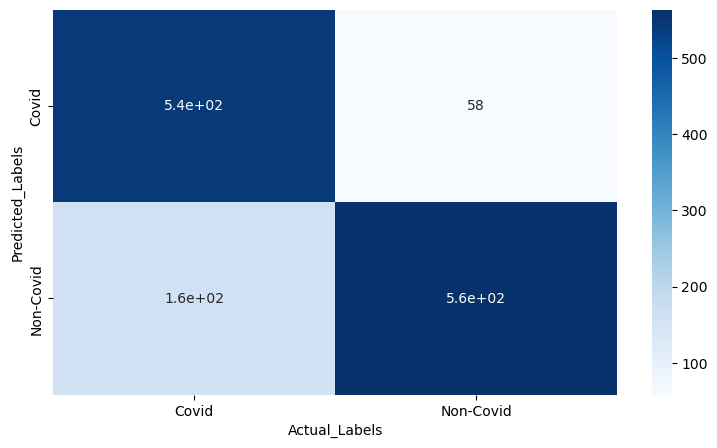

test accuracy = 83.5090361445783%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.8351
Precision: 0.8449
Recall: 0.8351
F1 Score: 0.8349


In [ ]:
print('--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------')
getModelEvaluation(FL_CovidCNN_model,X_test_combined_iid,y_test_combined_iid)

--------------------- Student Model Evaluation on Dataset1 ------------------------
9/9 [==============================] - 1s 142ms/step


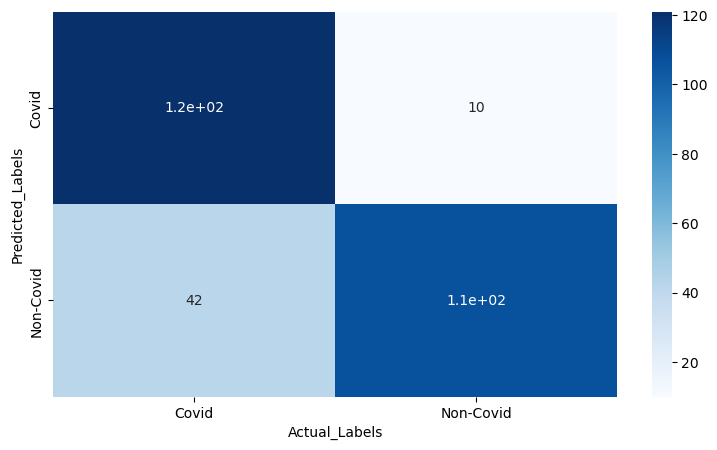

test accuracy = 81.42857142857143%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.8143
Precision: 0.8378
Recall: 0.8143
F1 Score: 0.8153
--------------------- Student Model Evaluation on Dataset2 ------------------------
25/25 [==============================] - 3s 138ms/step


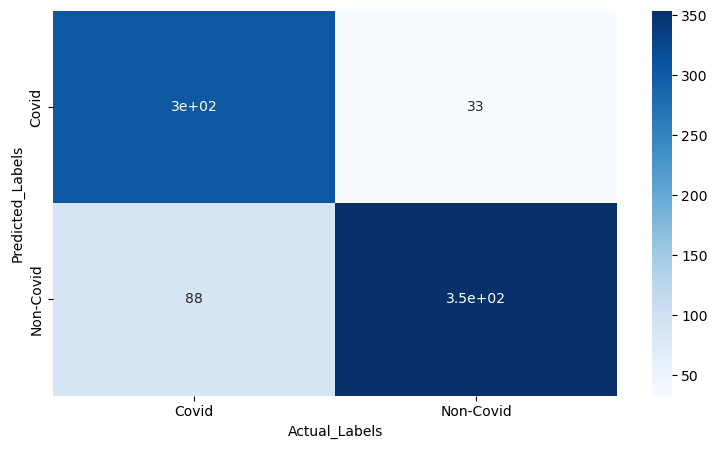

test accuracy = 84.48717948717949%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.8449
Precision: 0.852
Recall: 0.8449
F1 Score: 0.8442
--------------------- Student Model Evaluation on Dataset3 ------------------------
9/9 [==============================] - 2s 196ms/step


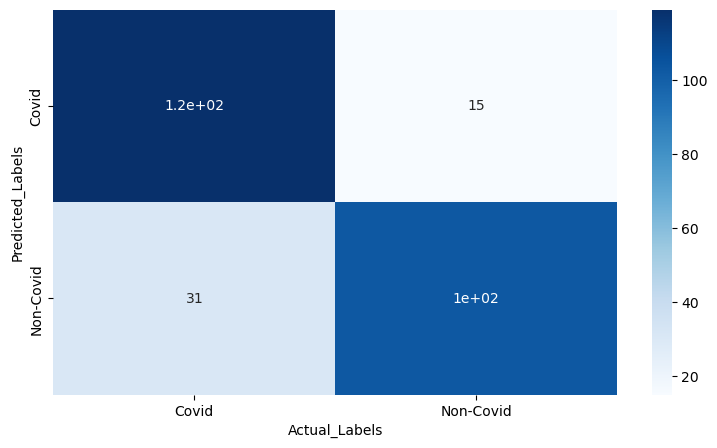

test accuracy = 82.83582089552239%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.8284
Precision: 0.8355
Recall: 0.8284
F1 Score: 0.829


In [ ]:
print('--------------------- Student Model Evaluation on Dataset1 ------------------------')
getModelEvaluation(FL_CovidCNN_model,test_features_dataset1_fed_iid,test_labels_dataset1_fed_iid)
print('--------------------- Student Model Evaluation on Dataset2 ------------------------')
getModelEvaluation(FL_CovidCNN_model,test_features_dataset2_fed_iid,test_labels_dataset2_fed_iid)
print('--------------------- Student Model Evaluation on Dataset3 ------------------------')
getModelEvaluation(FL_CovidCNN_model,test_features_dataset3_fed_iid,test_labels_dataset3_fed_iid)

In [ ]:
FL_CovidCNN_model.save('gsm_iid_unbalanced.h5')

/home/rkannan/miniconda3/envs/richard_tf_fedLearning/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### federated_train_data_IID_balanced

In [ ]:
server_state = fedavg_process.initialize()
for round in tqdm(range(50)):
    server_state = fedavg_process.next(server_state, federated_train_data_IID_balanced)
    FL_CovidCNN_model = evaluate(server_state,combined_test_data_iid)
    loss = list(FL_CovidCNN_model.get_metrics_result().values())[0].numpy()
    accuracy = list(FL_CovidCNN_model.get_metrics_result().values())[1].numpy()
    metrics['loss'].append(loss)
    metrics['accuracy'].append(accuracy)

  0%|                                                    | 0/50 [00:00<?, ?it/s]

67/67 [==============================] - 5s 67ms/step - loss: 0.6535 - categorical_accuracy: 0.5316


  2%|▉                                           | 1/50 [01:00<49:19, 60.40s/it]

67/67 [==============================] - 6s 90ms/step - loss: 0.6570 - categorical_accuracy: 0.6913


  4%|█▊                                          | 2/50 [01:51<44:05, 55.11s/it]

67/67 [==============================] - 5s 67ms/step - loss: 0.6844 - categorical_accuracy: 0.5256


  6%|██▋                                         | 3/50 [02:52<45:07, 57.60s/it]

67/67 [==============================] - 6s 88ms/step - loss: 0.6852 - categorical_accuracy: 0.5090


  8%|███▌                                        | 4/50 [03:37<40:29, 52.82s/it]

67/67 [==============================] - 4s 61ms/step - loss: 0.6745 - categorical_accuracy: 0.5226


 10%|████▍                                       | 5/50 [04:44<43:23, 57.85s/it]

67/67 [==============================] - 3s 44ms/step - loss: 0.6703 - categorical_accuracy: 0.5489


 12%|█████▎                                      | 6/50 [05:27<38:45, 52.86s/it]

67/67 [==============================] - 6s 90ms/step - loss: 0.6676 - categorical_accuracy: 0.5730


 14%|██████▏                                     | 7/50 [06:34<41:05, 57.34s/it]

67/67 [==============================] - 3s 40ms/step - loss: 0.6610 - categorical_accuracy: 0.6039


 16%|███████                                     | 8/50 [07:23<38:23, 54.84s/it]

67/67 [==============================] - 6s 91ms/step - loss: 0.6545 - categorical_accuracy: 0.6175


 18%|███████▉                                    | 9/50 [08:22<38:17, 56.04s/it]

67/67 [==============================] - 5s 67ms/step - loss: 0.6444 - categorical_accuracy: 0.6355


 20%|████████▌                                  | 10/50 [09:20<37:40, 56.50s/it]

67/67 [==============================] - 6s 89ms/step - loss: 0.6334 - categorical_accuracy: 0.6566


 22%|█████████▍                                 | 11/50 [10:15<36:32, 56.22s/it]

67/67 [==============================] - 5s 66ms/step - loss: 0.6199 - categorical_accuracy: 0.6687


 24%|██████████▎                                | 12/50 [11:15<36:12, 57.18s/it]

67/67 [==============================] - 6s 90ms/step - loss: 0.6062 - categorical_accuracy: 0.6883


 26%|███████████▏                               | 13/50 [12:04<33:48, 54.84s/it]

67/67 [==============================] - 5s 67ms/step - loss: 0.5927 - categorical_accuracy: 0.6958


 28%|████████████                               | 14/50 [13:07<34:25, 57.38s/it]

67/67 [==============================] - 3s 43ms/step - loss: 0.5785 - categorical_accuracy: 0.7086


 30%|████████████▉                              | 15/50 [13:50<30:55, 53.01s/it]

67/67 [==============================] - 6s 89ms/step - loss: 0.5634 - categorical_accuracy: 0.7176


 32%|█████████████▊                             | 16/50 [14:58<32:37, 57.57s/it]

67/67 [==============================] - 3s 42ms/step - loss: 0.5491 - categorical_accuracy: 0.7297


 34%|██████████████▌                            | 17/50 [15:46<30:03, 54.66s/it]

67/67 [==============================] - 6s 90ms/step - loss: 0.5378 - categorical_accuracy: 0.7364


 36%|███████████████▍                           | 18/50 [16:54<31:11, 58.50s/it]

67/67 [==============================] - 3s 43ms/step - loss: 0.5277 - categorical_accuracy: 0.7387


 38%|████████████████▎                          | 19/50 [17:45<29:07, 56.38s/it]

67/67 [==============================] - 7s 91ms/step - loss: 0.5187 - categorical_accuracy: 0.7432


 40%|█████████████████▏                         | 20/50 [18:51<29:38, 59.28s/it]

67/67 [==============================] - 3s 46ms/step - loss: 0.5103 - categorical_accuracy: 0.7470


 42%|██████████████████                         | 21/50 [19:45<27:54, 57.74s/it]

67/67 [==============================] - 7s 93ms/step - loss: 0.5028 - categorical_accuracy: 0.7500


 44%|██████████████████▉                        | 22/50 [20:44<27:05, 58.04s/it]

67/67 [==============================] - 5s 66ms/step - loss: 0.4967 - categorical_accuracy: 0.7575


 46%|███████████████████▊                       | 23/50 [21:41<25:55, 57.62s/it]

67/67 [==============================] - 7s 97ms/step - loss: 0.4902 - categorical_accuracy: 0.7658


 48%|████████████████████▋                      | 24/50 [22:33<24:19, 56.15s/it]

67/67 [==============================] - 5s 66ms/step - loss: 0.4845 - categorical_accuracy: 0.7711


 50%|█████████████████████▌                     | 25/50 [23:34<23:54, 57.37s/it]

67/67 [==============================] - 6s 83ms/step - loss: 0.4793 - categorical_accuracy: 0.7877


 52%|██████████████████████▎                    | 26/50 [24:19<21:27, 53.65s/it]

67/67 [==============================] - 4s 54ms/step - loss: 0.4745 - categorical_accuracy: 0.7937


 54%|███████████████████████▏                   | 27/50 [25:24<21:55, 57.18s/it]

67/67 [==============================] - 3s 41ms/step - loss: 0.4700 - categorical_accuracy: 0.8005


 56%|████████████████████████                   | 28/50 [26:09<19:37, 53.54s/it]

67/67 [==============================] - 6s 91ms/step - loss: 0.4658 - categorical_accuracy: 0.8057


 58%|████████████████████████▉                  | 29/50 [27:14<19:58, 57.08s/it]

67/67 [==============================] - 3s 41ms/step - loss: 0.4621 - categorical_accuracy: 0.8125


 60%|█████████████████████████▊                 | 30/50 [28:04<18:15, 54.78s/it]

67/67 [==============================] - 7s 93ms/step - loss: 0.4585 - categorical_accuracy: 0.8110


 62%|██████████████████████████▋                | 31/50 [29:04<17:50, 56.36s/it]

67/67 [==============================] - 5s 66ms/step - loss: 0.4555 - categorical_accuracy: 0.8102


 64%|███████████████████████████▌               | 32/50 [29:59<16:50, 56.13s/it]

67/67 [==============================] - 7s 93ms/step - loss: 0.4512 - categorical_accuracy: 0.8110


 66%|████████████████████████████▍              | 33/50 [30:55<15:53, 56.09s/it]

67/67 [==============================] - 5s 67ms/step - loss: 0.4476 - categorical_accuracy: 0.8117


 68%|█████████████████████████████▏             | 34/50 [31:52<14:59, 56.22s/it]

67/67 [==============================] - 7s 95ms/step - loss: 0.4447 - categorical_accuracy: 0.8133


 70%|██████████████████████████████             | 35/50 [32:44<13:43, 54.90s/it]

67/67 [==============================] - 5s 67ms/step - loss: 0.4429 - categorical_accuracy: 0.8102


 72%|██████████████████████████████▉            | 36/50 [33:48<13:27, 57.65s/it]

67/67 [==============================] - 4s 63ms/step - loss: 0.4412 - categorical_accuracy: 0.8110


 74%|███████████████████████████████▊           | 37/50 [34:33<11:39, 53.83s/it]

67/67 [==============================] - 4s 61ms/step - loss: 0.4391 - categorical_accuracy: 0.8110


 76%|████████████████████████████████▋          | 38/50 [35:39<11:30, 57.54s/it]

67/67 [==============================] - 3s 43ms/step - loss: 0.4362 - categorical_accuracy: 0.8148


 78%|█████████████████████████████████▌         | 39/50 [36:23<09:48, 53.51s/it]

67/67 [==============================] - 6s 90ms/step - loss: 0.4332 - categorical_accuracy: 0.8170


 80%|██████████████████████████████████▍        | 40/50 [37:23<09:14, 55.42s/it]

67/67 [==============================] - 5s 67ms/step - loss: 0.4313 - categorical_accuracy: 0.8155


 82%|███████████████████████████████████▎       | 41/50 [38:20<08:24, 56.06s/it]

67/67 [==============================] - 6s 91ms/step - loss: 0.4300 - categorical_accuracy: 0.8185


 84%|████████████████████████████████████       | 42/50 [39:15<07:25, 55.65s/it]

67/67 [==============================] - 5s 68ms/step - loss: 0.4285 - categorical_accuracy: 0.8238


 86%|████████████████████████████████████▉      | 43/50 [40:12<06:32, 56.04s/it]

67/67 [==============================] - 6s 90ms/step - loss: 0.4267 - categorical_accuracy: 0.8268


 88%|█████████████████████████████████████▊     | 44/50 [41:00<05:21, 53.57s/it]

67/67 [==============================] - 3s 39ms/step - loss: 0.4248 - categorical_accuracy: 0.8253


 90%|██████████████████████████████████████▋    | 45/50 [42:03<04:42, 56.51s/it]

67/67 [==============================] - 3s 38ms/step - loss: 0.4231 - categorical_accuracy: 0.8245


 92%|███████████████████████████████████████▌   | 46/50 [42:41<03:23, 50.91s/it]

67/67 [==============================] - 3s 37ms/step - loss: 0.4216 - categorical_accuracy: 0.8253


 94%|████████████████████████████████████████▍  | 47/50 [43:29<02:30, 50.03s/it]

67/67 [==============================] - 3s 46ms/step - loss: 0.4200 - categorical_accuracy: 0.8268


 96%|█████████████████████████████████████████▎ | 48/50 [44:16<01:38, 49.02s/it]

67/67 [==============================] - 6s 88ms/step - loss: 0.4186 - categorical_accuracy: 0.8283


 98%|██████████████████████████████████████████▏| 49/50 [45:16<00:52, 52.38s/it]

67/67 [==============================] - 5s 67ms/step - loss: 0.4169 - categorical_accuracy: 0.8298


100%|███████████████████████████████████████████| 50/50 [46:13<00:00, 55.48s/it]


--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------
42/42 [==============================] - 5s 104ms/step


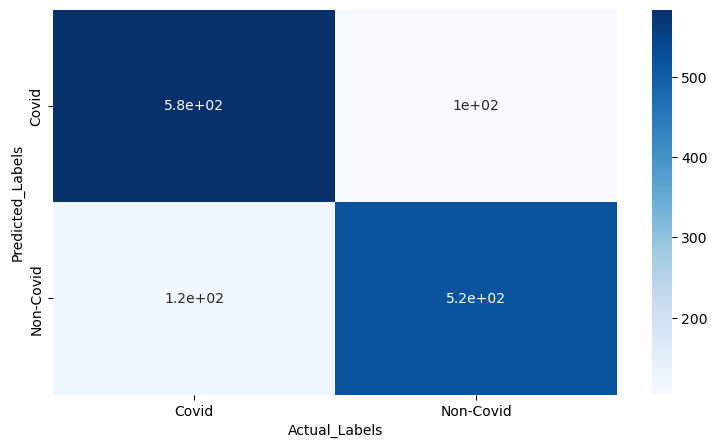

test accuracy = 82.98192771084338%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.8298
Precision: 0.8304
Recall: 0.8298
F1 Score: 0.8299


In [ ]:
print('--------------------- Student Model Evaluation on Dataset2 and Dataset3 ------------------------')
getModelEvaluation(FL_CovidCNN_model,X_test_combined_iid,y_test_combined_iid)

--------------------- Student Model Evaluation on Dataset1 ------------------------
9/9 [==============================] - 1s 103ms/step


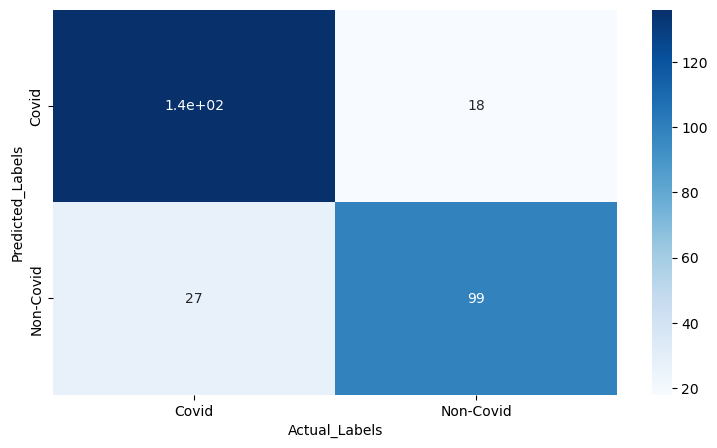

test accuracy = 83.92857142857143%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.8393
Precision: 0.8424
Recall: 0.8393
F1 Score: 0.84
--------------------- Student Model Evaluation on Dataset2 ------------------------
25/25 [==============================] - 3s 104ms/step


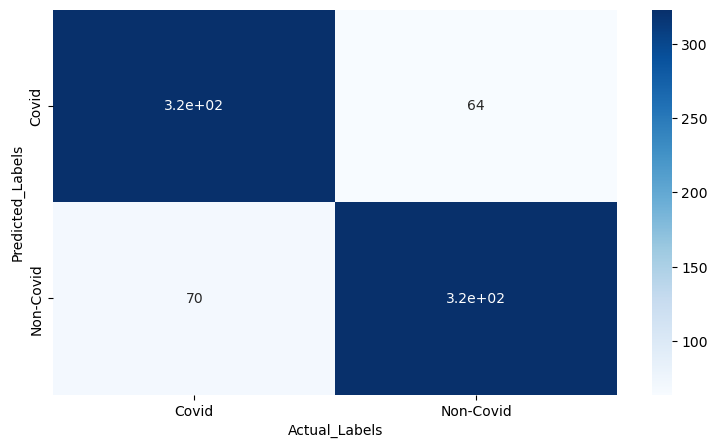

test accuracy = 82.82051282051283%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.8282
Precision: 0.8283
Recall: 0.8282
F1 Score: 0.8282
--------------------- Student Model Evaluation on Dataset3 ------------------------
9/9 [==============================] - 1s 103ms/step


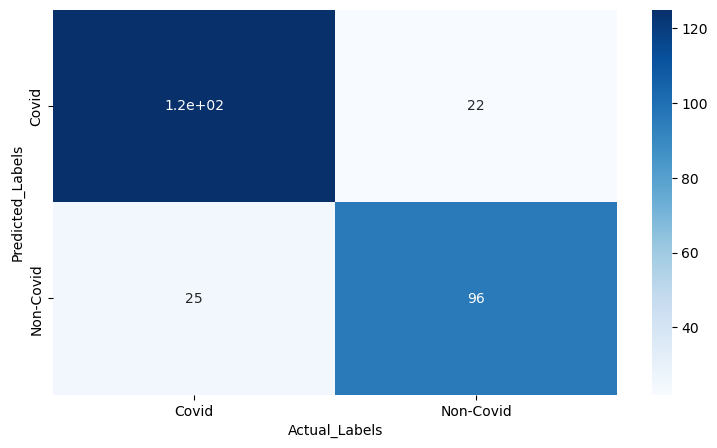

test accuracy = 82.46268656716418%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.8246
Precision: 0.8253
Recall: 0.8246
F1 Score: 0.8248


In [ ]:
print('--------------------- Student Model Evaluation on Dataset1 ------------------------')
getModelEvaluation(FL_CovidCNN_model,test_features_dataset1_fed_iid,test_labels_dataset1_fed_iid)
print('--------------------- Student Model Evaluation on Dataset2 ------------------------')
getModelEvaluation(FL_CovidCNN_model,test_features_dataset2_fed_iid,test_labels_dataset2_fed_iid)
print('--------------------- Student Model Evaluation on Dataset3 ------------------------')
getModelEvaluation(FL_CovidCNN_model,test_features_dataset3_fed_iid,test_labels_dataset3_fed_iid)

In [ ]:
FL_CovidCNN_model.save('gsm_iid_balanced.h5')

/home/rkannan/miniconda3/envs/richard_tf_fedLearning/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
